#  Sugeno

In [22]:
# imports
#!pip install scikit-fuzzy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from scipy.optimize import least_squares

In [23]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

# Ra radio interno, Rb radio externo
def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15
        
    scaler = MinMaxScaler()
    scaler.fit(data) 
    ndata = scaler.transform(data)
    
    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)
   
    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]
    
    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])            
        restarP = True  
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else: 
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

In [24]:
class Sugeno:
    def __init__(self, data, cluster_alg="K", sigma_mf = 0.1, K=6, Ra=0.2, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
        self.cluster_alg = cluster_alg
        self.K = K
        self.Ra = Ra
        self.Rb = Rb
        self.AcceptRatio=AcceptRatio
        self.RejectRatio=RejectRatio
        self.X = data
        self.fitted = False
        self.sigma_mf = sigma_mf

    def fit_clusters(self):
        """
        Entrena un modelo de clustering.
        
        Opciones:
        - KMeans si cluster_alg = "K"
        - Clustering sustractivo otherwise

        """
        if self.cluster_alg =="K":
            KM = KMeans(n_clusters=self.K, init= 'k-means++', random_state=0, max_iter=400, n_init=10).fit(self.X)
            # me quedo con los labels y los centros
            self.labels = KM.labels_
            self.centers = KM.cluster_centers_
            self.fitted = True
        else:
            self.labels, self.centers = subclust2(self.X, Ra=self.Ra, Rb=self.Rb, AcceptRatio=self.AcceptRatio, RejectRatio=self.RejectRatio)
            self.fitted = True
            # subclust2(X, 0.2, Rb=0, AcceptRatio=0.3, RejectRatio=0.1)

    def get_centers(self):
        """
        Retorna los centros de cluster o None si no se ha entrenado
        """
        if self.fitted:
            return self.centers
        else:
            print("Aun no se ha fiteado ningún modelo")
            return None

    def get_labels(self):
        """
        Retorna los labels para todos los datos
        o None si no se ha entrenado
        """
        if self.fitted:
            return self.labels
        else:
            print("Aun no se ha fiteado ningún modelo")
            return None

    def get_n_centers(self):
        """
        Retorna la cantidad de centros de cluster, o cero si no se ha entrenado
        """
        if self.fitted:
            return self.labels
        else:
            print("Aun no se ha fiteado ningún modelo")
            return []

    def plot_original_color_by_cluster(self):
        """
        Plotea los datos originales, coloreados por los centros de cluster

        """
        n = self.get_n_centers()
        # print(n)
        if len(n)!=0:
            labels = self.get_labels()
            options_col = np.linspace(0, 1, len(n))
            label_color = [options_col[x] for x in labels]


            plt.figure(figsize=(8,8))
            plt.scatter(self.X[:,1], self.X[:,0], c=label_color)
            plt.title("Datos coloreados con los centros hallados con algoritmo de clustering")

    def get_medias(self):
        centers = self.get_centers()

        if centers is not None:
            medias = []
            for cx, cy in centers:
                medias.append(cy)
            medias = np.array(medias)
            medias.sort()

        return medias


    def plot_gaussians(self):
        # me quedo con los centros en la variable independiente (eje x o de tensiones)
        centers = self.get_centers()

        if centers is not None:
            medias = []
            for cx, cy in centers:
                medias.append(cy)
            medias = np.array(medias)
            medias.sort()

            # Ploteo con todas las gaussiandas

            
            x1 = self.X[:,1]
            y1 = self.X[:,0]

            y_t = []
            for med in medias:
                y_t.append(fuzz.gaussmf(x1, med, self.sigma_mf)) 
            
            self.y_t = y_t
            
            plt.figure(figsize=(8,8))
            plt.plot(x1, y1, 'r', linewidth=2, marker="o")
            for y in y_t:
                plt.plot(x1, y)
            plt.title("Datos con las gaussianas generadas por clustering")

        else:
            print("No es posible plotear porque no se ha inicializado un modelo de cluster")


    def get_sugeno_model_and_plot(self):
        
        x1 = self.X[:,1]
        y1 = self.X[:,0]
        medias = self.get_medias()


        y_t = []

        # El ancho de las gaussianas (desv, es un parametro importante)
        for med in medias:
            y_t.append(fuzz.gaussmf(x1, med, self.sigma_mf)) #ultimo era 0.35

        

        def y(theta, t):
            # salidas lineales todas
            mf = []
            funx = []
            for i in range(len(theta)//2):
                mf.append(fuzz.interp_membership(x1, y_t[i], t))
                funx.append(theta[2*i] * t + theta[2*i+1])
            mf = np.array(mf)
            funx = np.array(funx)
            num =   0
            den = 0
            for i in range(len(theta)//2):
                num += mf[i]*funx[i]
                den += mf[i]
            try :
                resultado =  num/den
            except:
                resultado = None
                print("Division por cero")
            return resultado

        ts = x1
        ys =y1

        def fun(theta):
            return y(theta, ts) - ys


        theta0= [0.1, 0,1]*30
        
        n2 = 2*len(medias)
        res1 = least_squares(fun, theta0[:n2])


        mse1 = (res1.fun ** 2).mean()
        #print("parametros obtenidos mediante least Squares:\n", res1.x)
        print("error cuadratico medio:\n", mse1)




        # ploteo curva obtenida vs datos originales
        y_pred= y(res1.x, x1)

        self.Y = y_pred

        plt.figure(figsize=(8,8))
        plt.plot(x1, y1, '.r')
        plt.plot(x1, y_pred, 'b')
        if self.cluster_alg=="K":
            str1 = "K means"
        else:
            str1 = "Clustering sustractivo"
        str2 = f"{self.centers.shape[0]} reglas"
        plt.title("Resultado final, curva generada mediante sugeno.\nAlgoritmo de cluster =  "+str1+". "+str2
            +"\nmse: "+str(mse1))
    
    def get_oversampling_and_plot(self,max_x=1,max_y=1,min_x=0,min_y=0):
        x1 = self.X[:,1]
        y1 = self.Y

        xo = []
        yo = []

        for i in range(len(x1)-1):
            xo.append((x1[i] + x1[i+1])/2) 

        print(xo)

        for i in range(len(xo)):
            yo.append((y1[i] + y1[i+1])/2)
        
        fig,ax1 = plt.subplots()

        
        ax1.plot(xo, yo, '2b',label='Datos de sobremuestreo')
        ax1.plot(self.X[:,1],self.X[:,0], '.r',label='Datos de originales')
        legend = ax1.legend(loc='upper right', shadow=False, fontsize='medium')
        ax2 = ax1.twiny()
        ax3 = ax1.twinx()
        ax2.set_xlim([min_x,max_x])
        ax3.set_ylim([min_y,max_y])
        plt.title("Datos originales y datos de sobremuestreo") 
        plt.show()

        


In [25]:
f = open("samplesVDA3.txt", "r")

y = []
i=1
for x in f:
    y.append(int(x))
    i=i+1
f.close()

y = np.asarray(y)

y_norm = (y - y.min())/(y.max()-y.min())
x = np.linspace(0,1,y.shape[0])
x_t=x*len(y)*2.5

X11 = np.array([y_norm,x]).T
MAXX = max(x_t)
MAXY = max(y)
MINY = min(y)

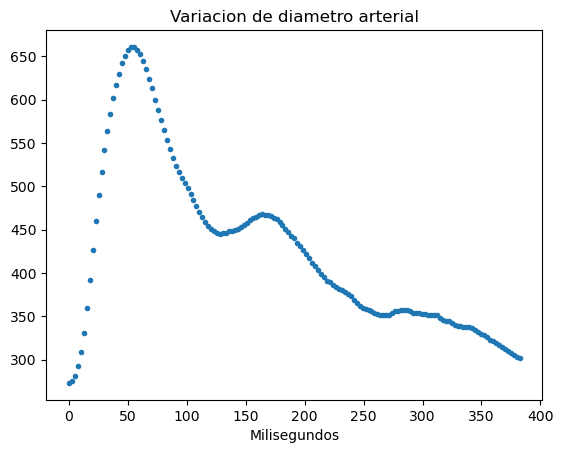

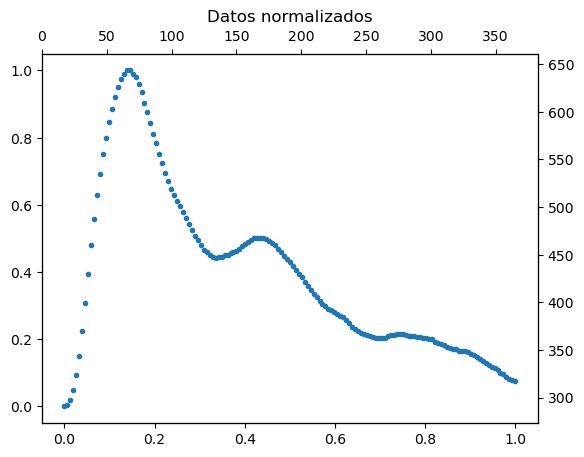

In [26]:

plt.plot(x_t,y,'.')
plt.title("Variacion de diametro arterial")
plt.xlabel("Milisegundos")
plt.show()

fig, ax1 = plt.subplots()

ax1.plot(X11[:,1],X11[:,0],'.')
ax2 = ax1.twiny()
ax3 = ax1.twinx()
ax2.set_xlim([0,MAXX])
ax3.set_ylim([MINY,MAXY])
plt.title("Datos normalizados")
plt.show()


In [27]:
#my_sug_VDA = Sugeno(X11, cluster_alg="K", K=10,Ra=0.4)

In [28]:
#my_sug_VDA.fit_clusters()

In [29]:
#my_sug_VDA.plot_original_color_by_cluster()

In [30]:
#my_sug_VDA.plot_gaussians()

In [31]:
#my_sug_VDA.get_sugeno_model_and_plot()

In [32]:
#Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X11)
    wcss.append(kmeans.inertia_)

C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\s

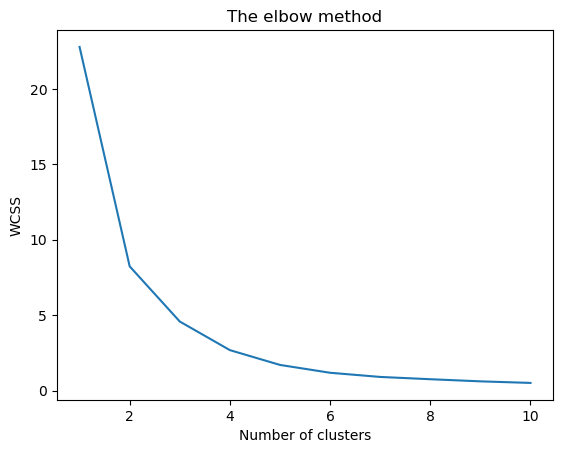

In [33]:
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.5662344175321901
For n_clusters = 6 The average silhouette_score is : 0.4358297989156284


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.36857677709715136
For n_clusters = 8 The average silhouette_score is : 0.37937552776801853
For n_clusters = 9 The average silhouette_score is : 0.38378664890664654


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.33034892966673807
For n_clusters = 11 The average silhouette_score is : 0.32674155621666945
For n_clusters = 12 The average silhouette_score is : 0.3124558625401678
For n_clusters = 13 The average silhouette_score is : 0.3269930141528776
For n_clusters = 14 The average silhouette_score is : 0.34049517108420263


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\s

For n_clusters = 15 The average silhouette_score is : 0.32301669881557027
For n_clusters = 16 The average silhouette_score is : 0.3245760250105525


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 17 The average silhouette_score is : 0.3306754035307484
For n_clusters = 18 The average silhouette_score is : 0.32367852345423537


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 19 The average silhouette_score is : 0.3249414782893464
For n_clusters = 20 The average silhouette_score is : 0.31988524056218026


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Francisco\AppData\Local\Temp\ipykernel_28744\3848664864.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2)
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment

For n_clusters = 21 The average silhouette_score is : 0.3296963237984396
For n_clusters = 22 The average silhouette_score is : 0.33310815668811705


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 23 The average silhouette_score is : 0.3347521727091755
For n_clusters = 24 The average silhouette_score is : 0.33613571225312283


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


For n_clusters = 25 The average silhouette_score is : 0.33549416710074564


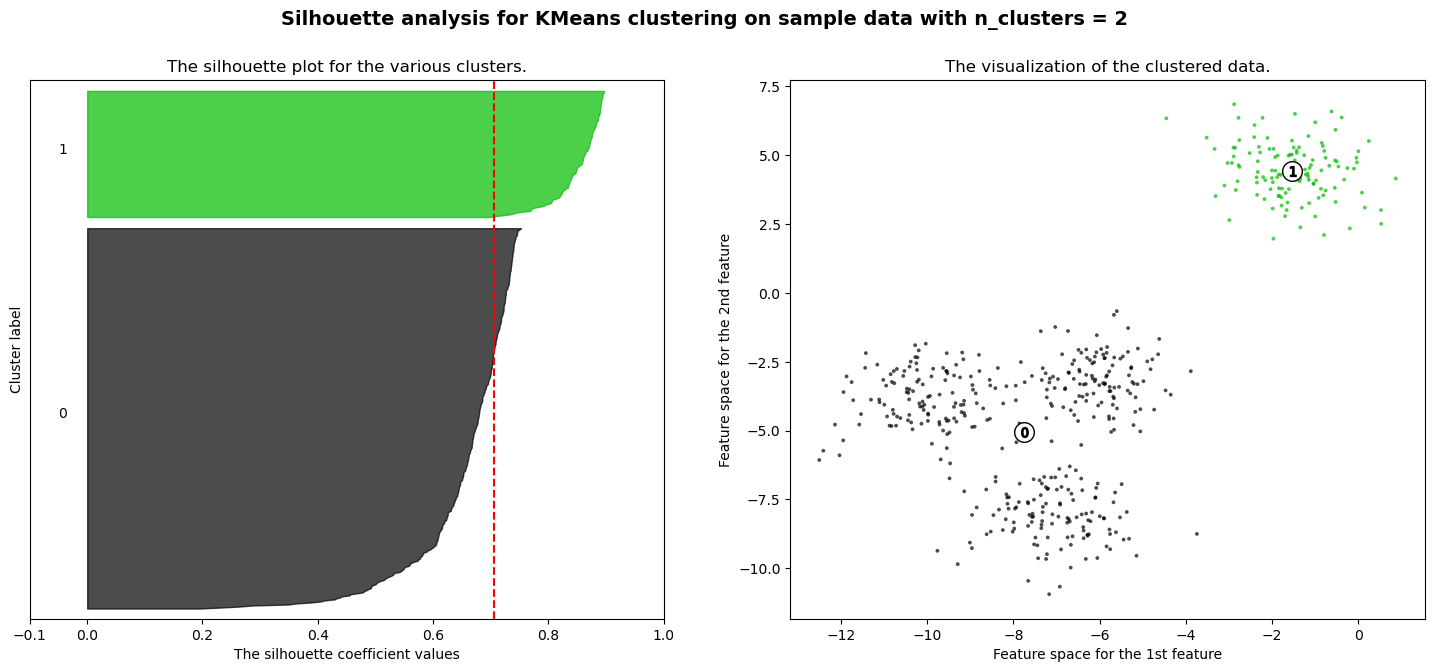

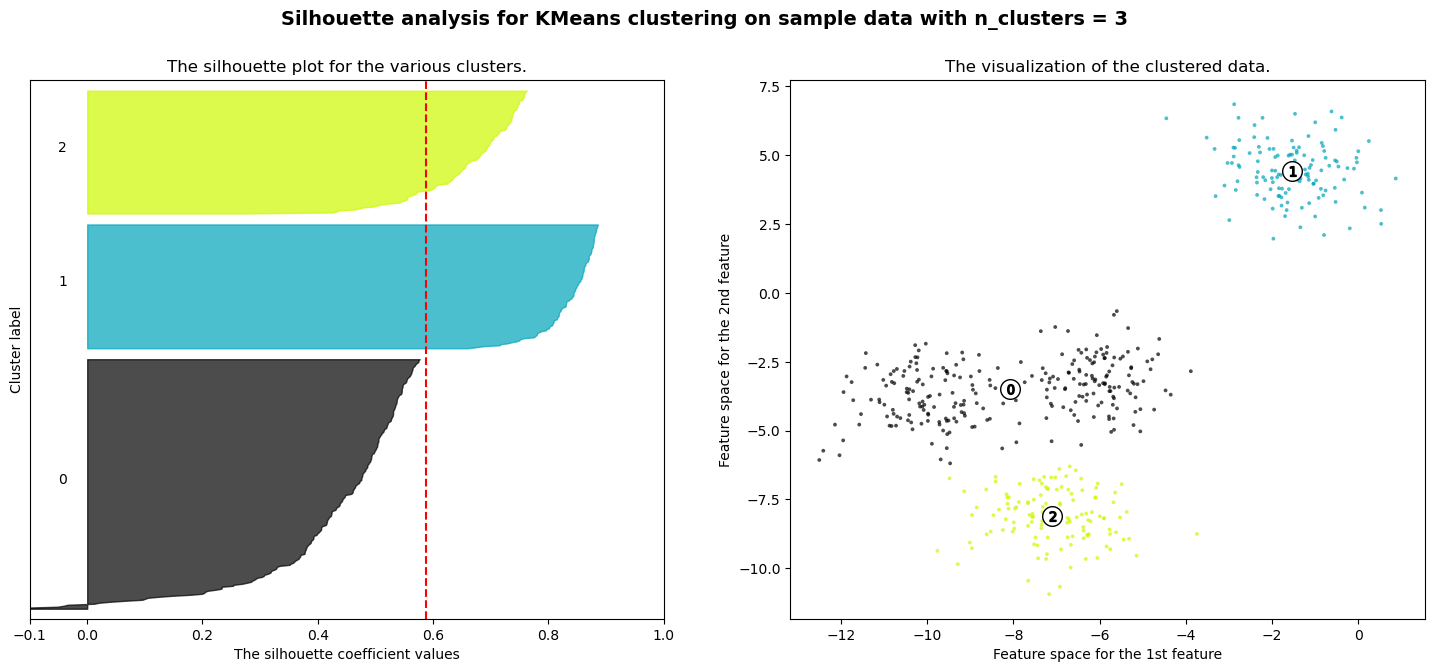

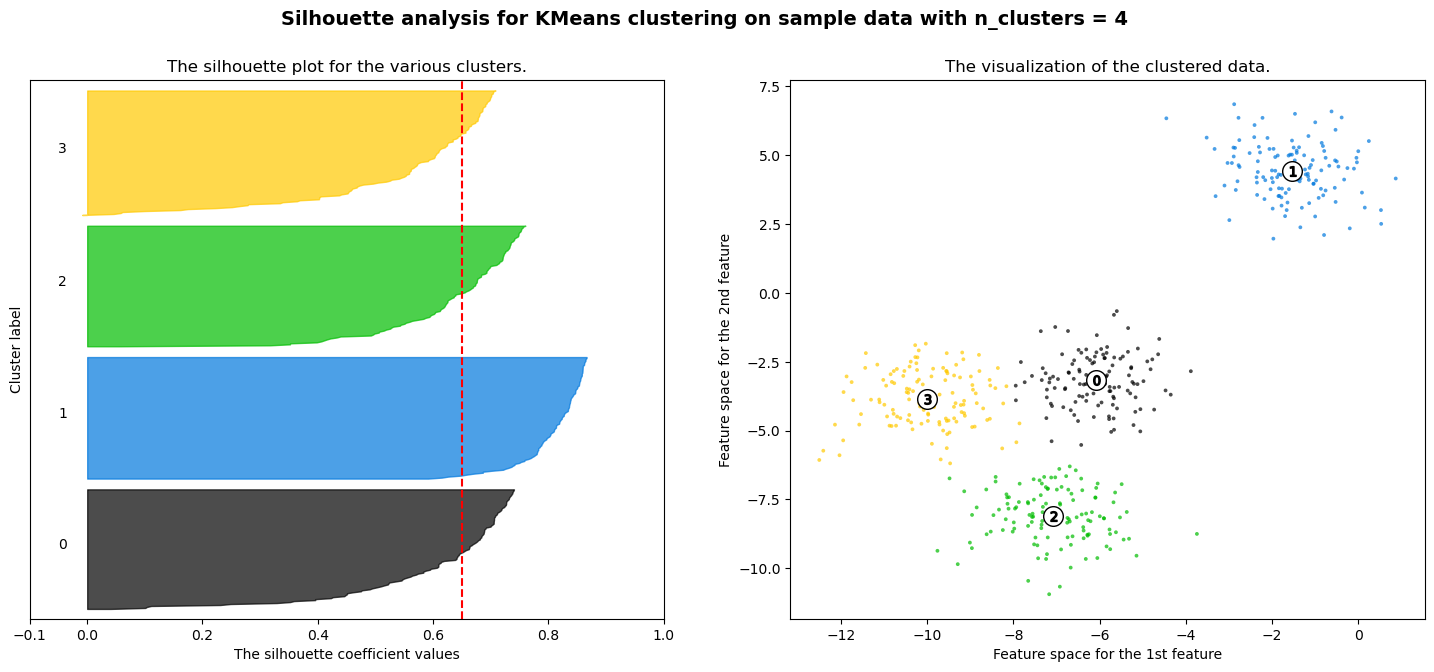

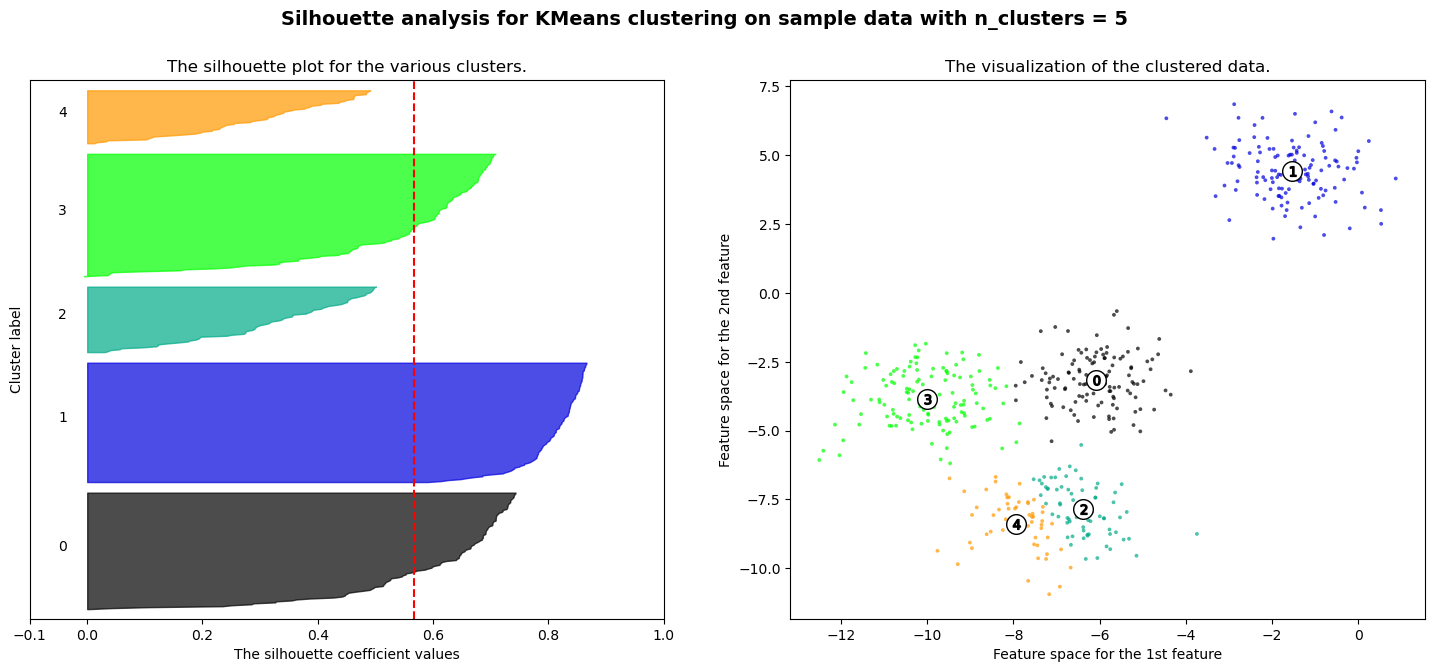

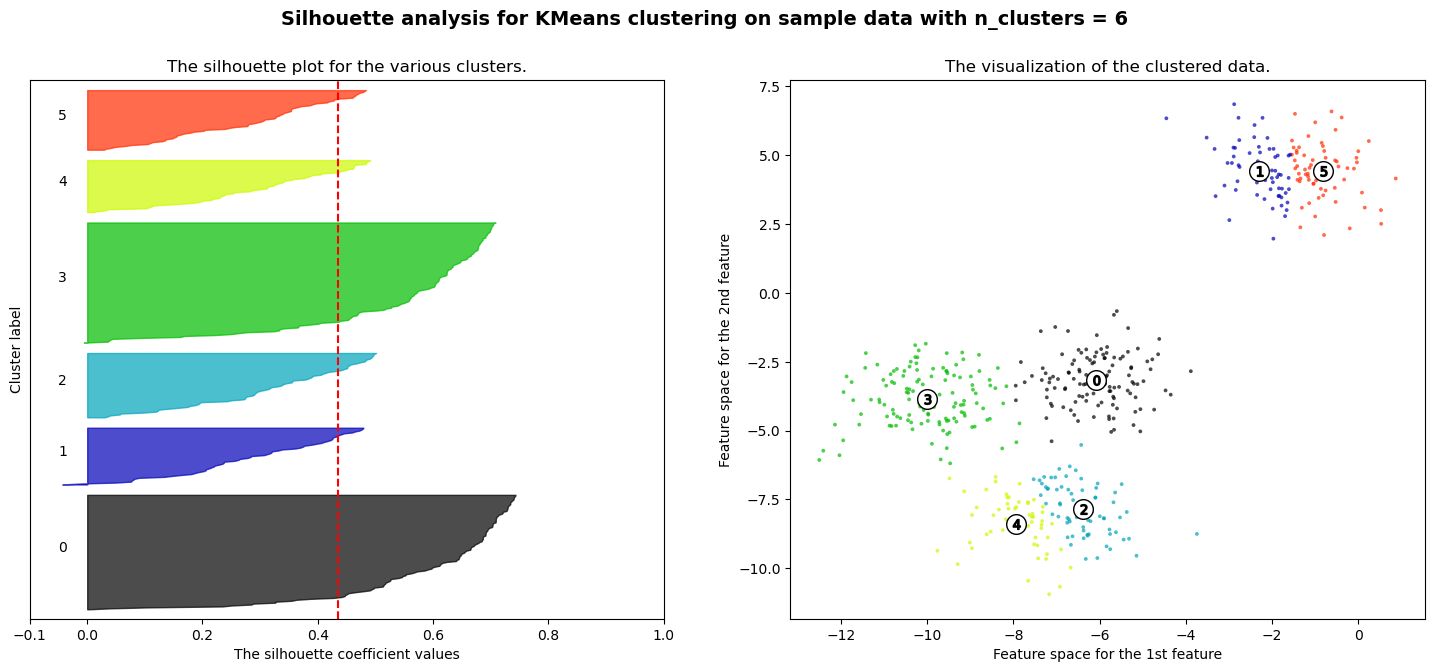

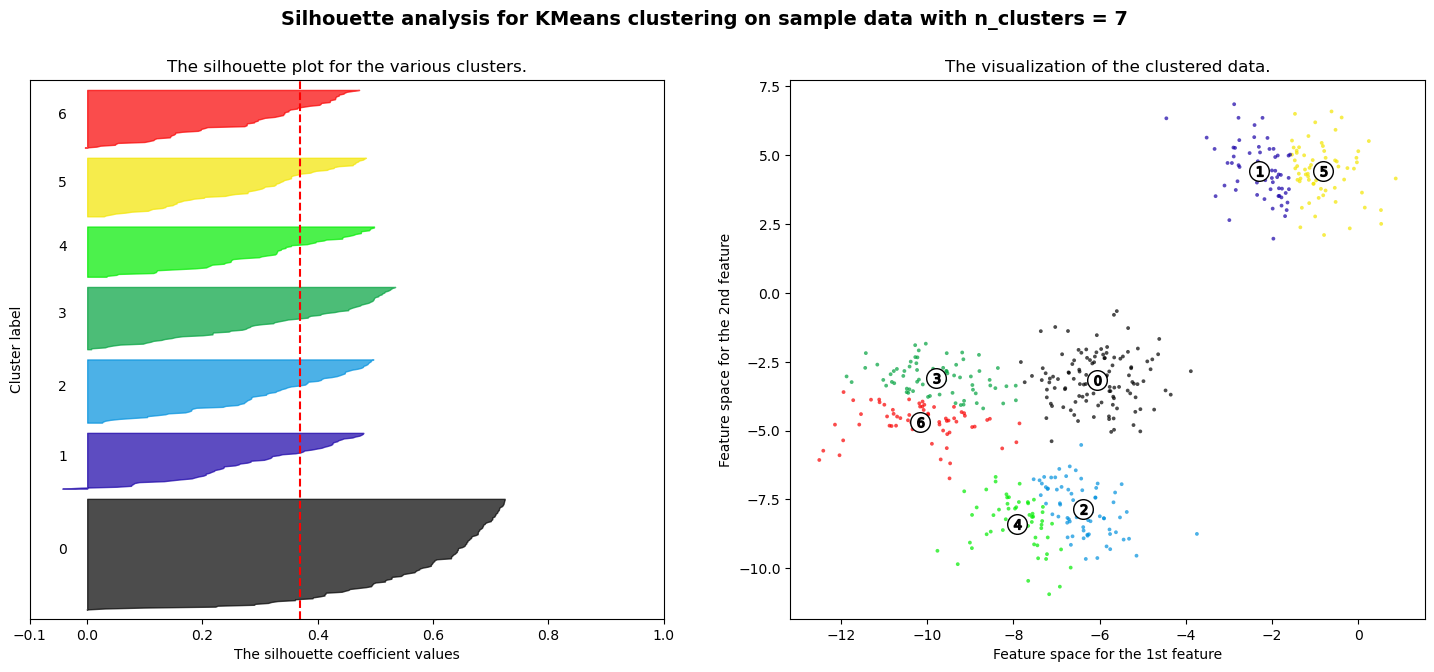

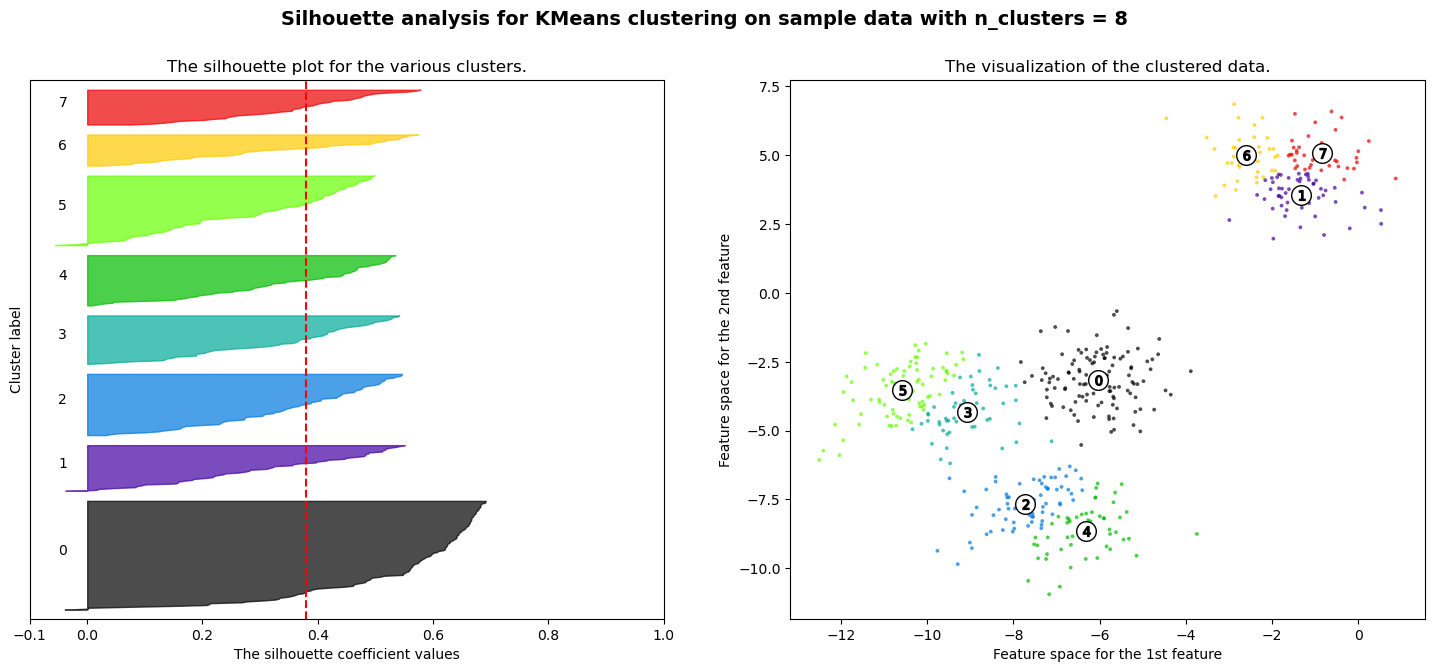

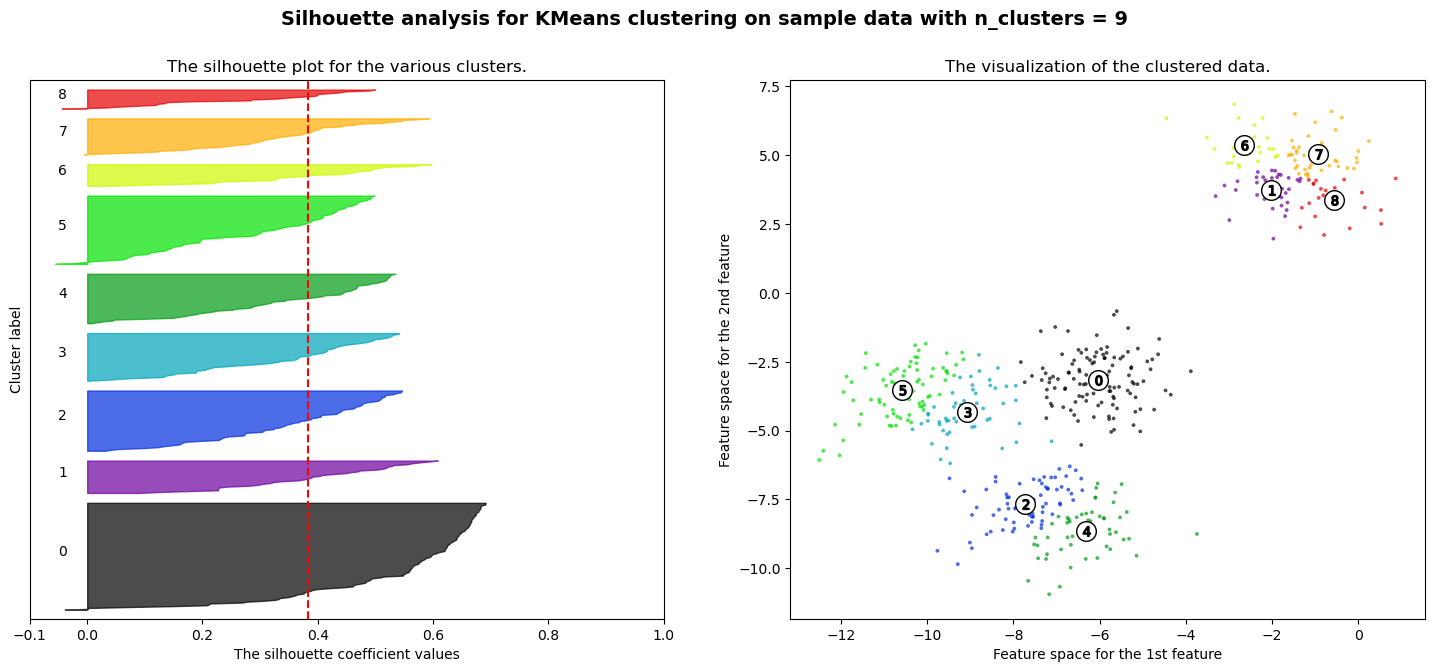

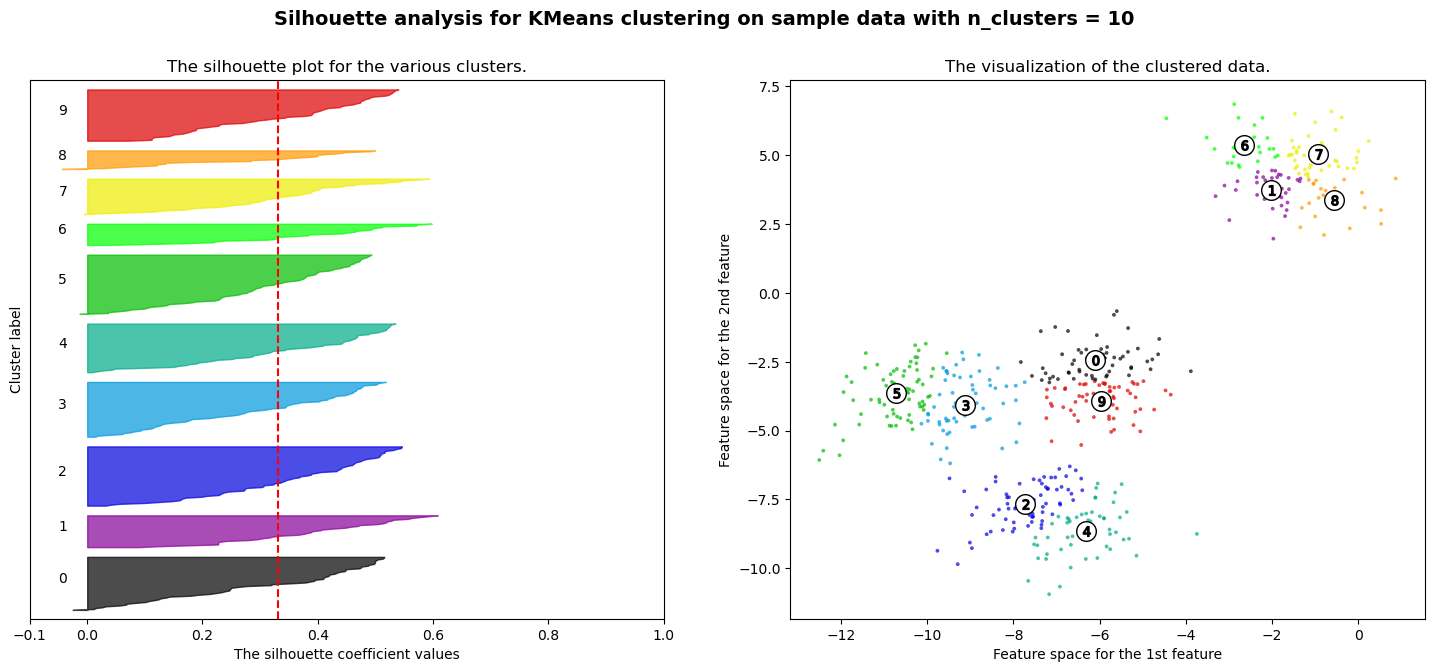

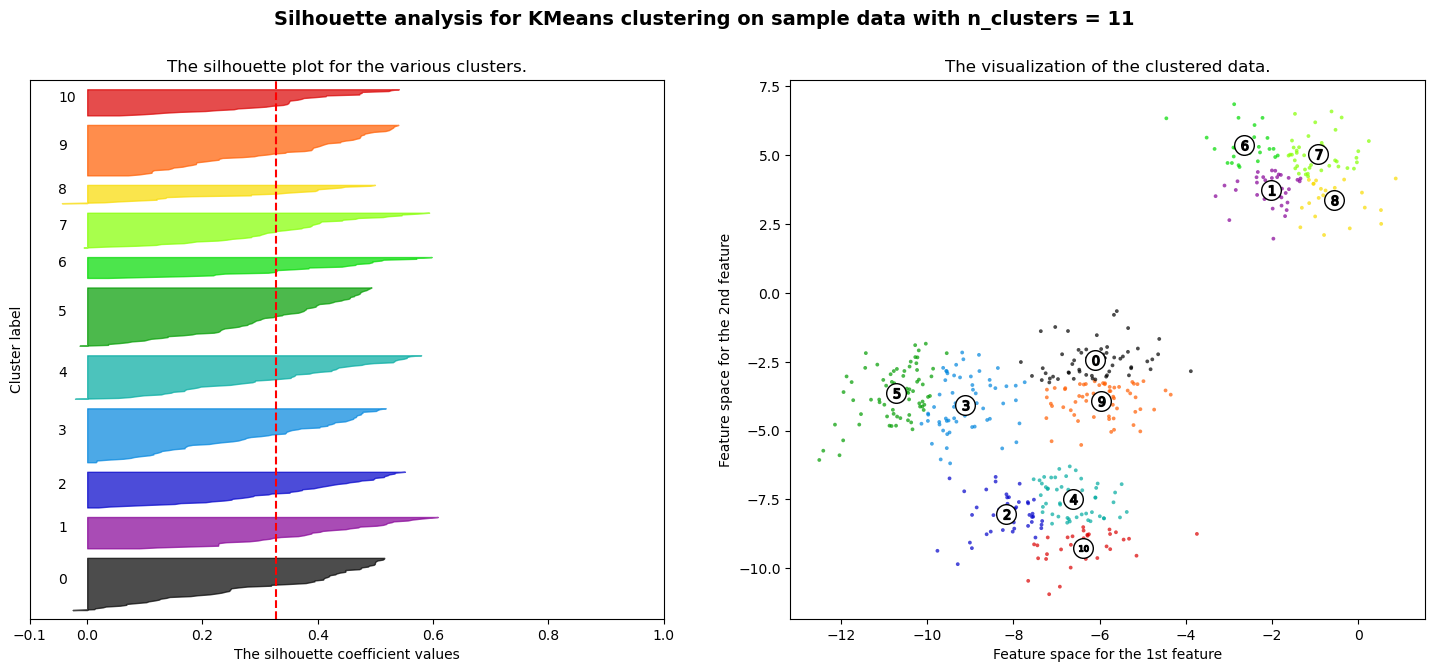

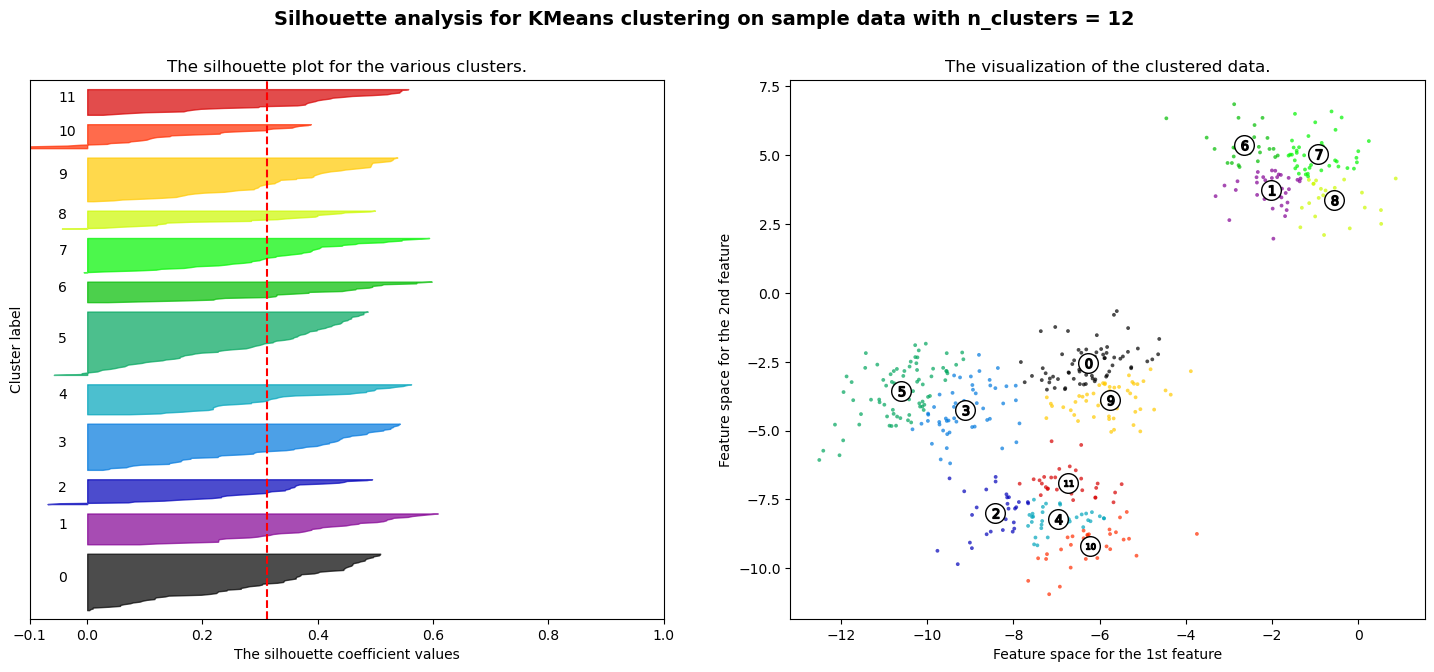

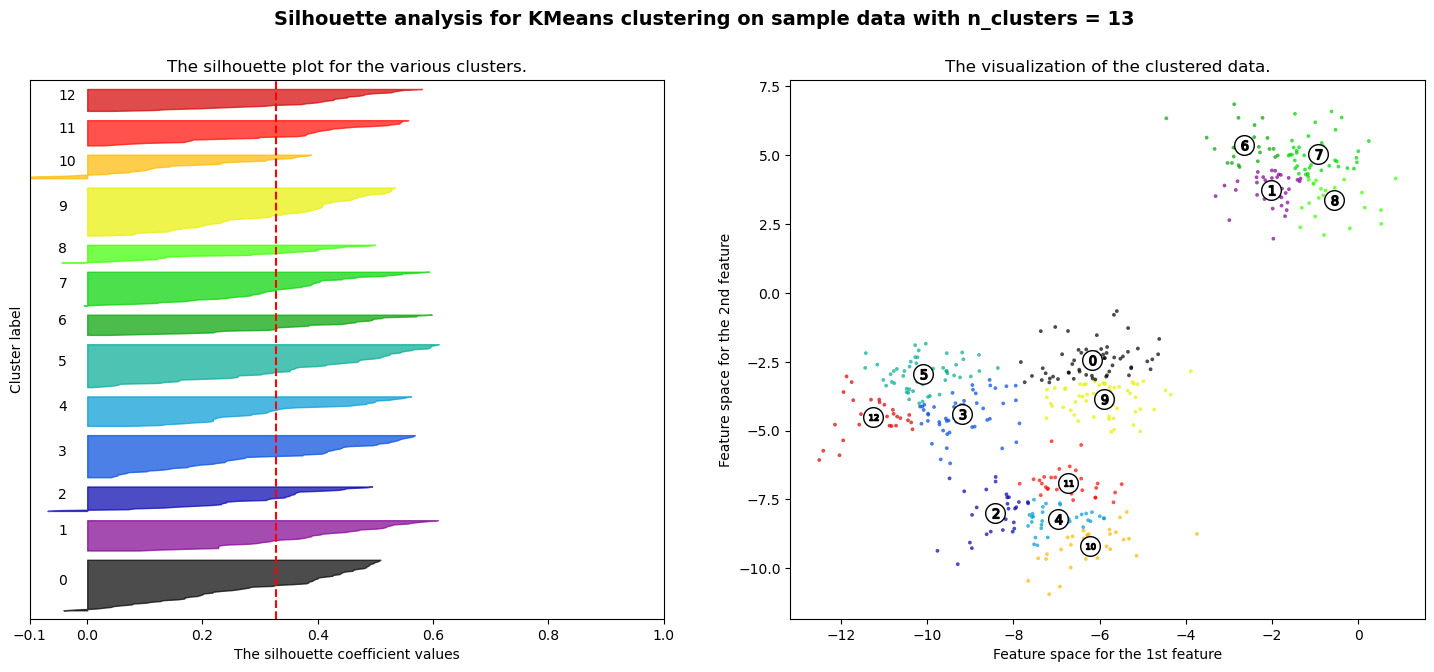

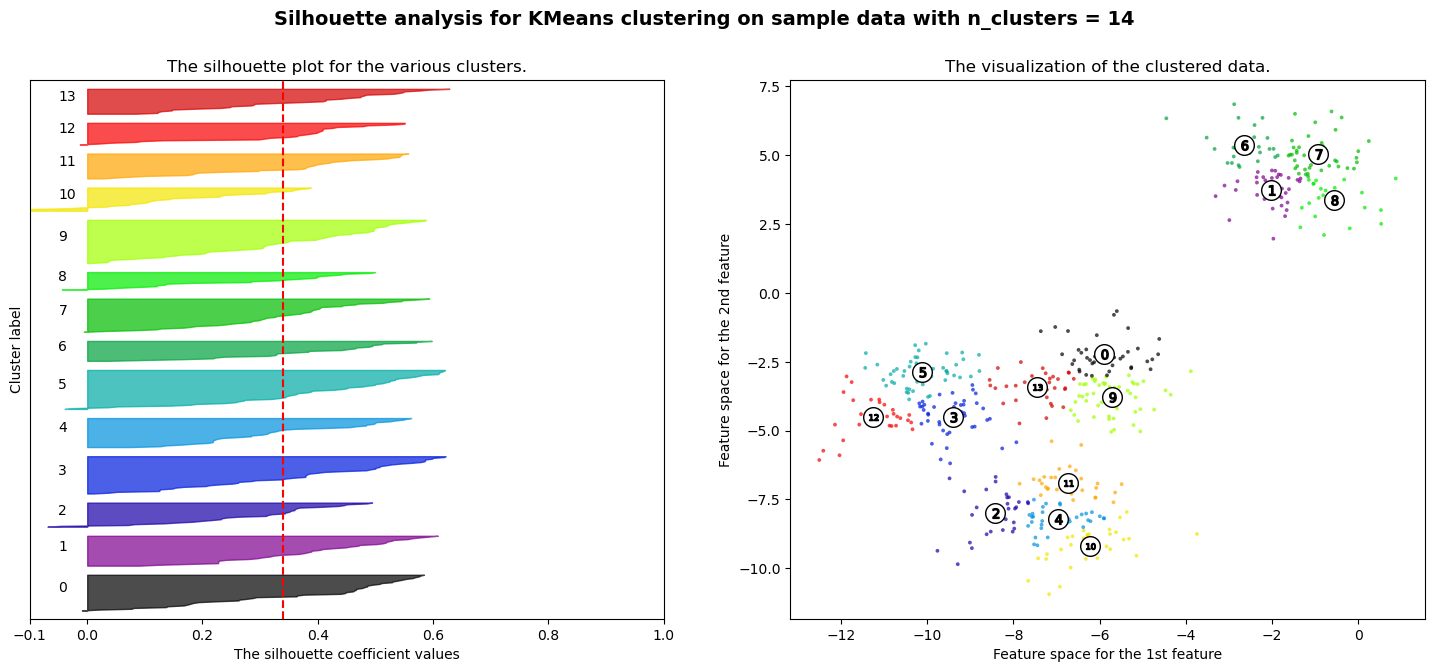

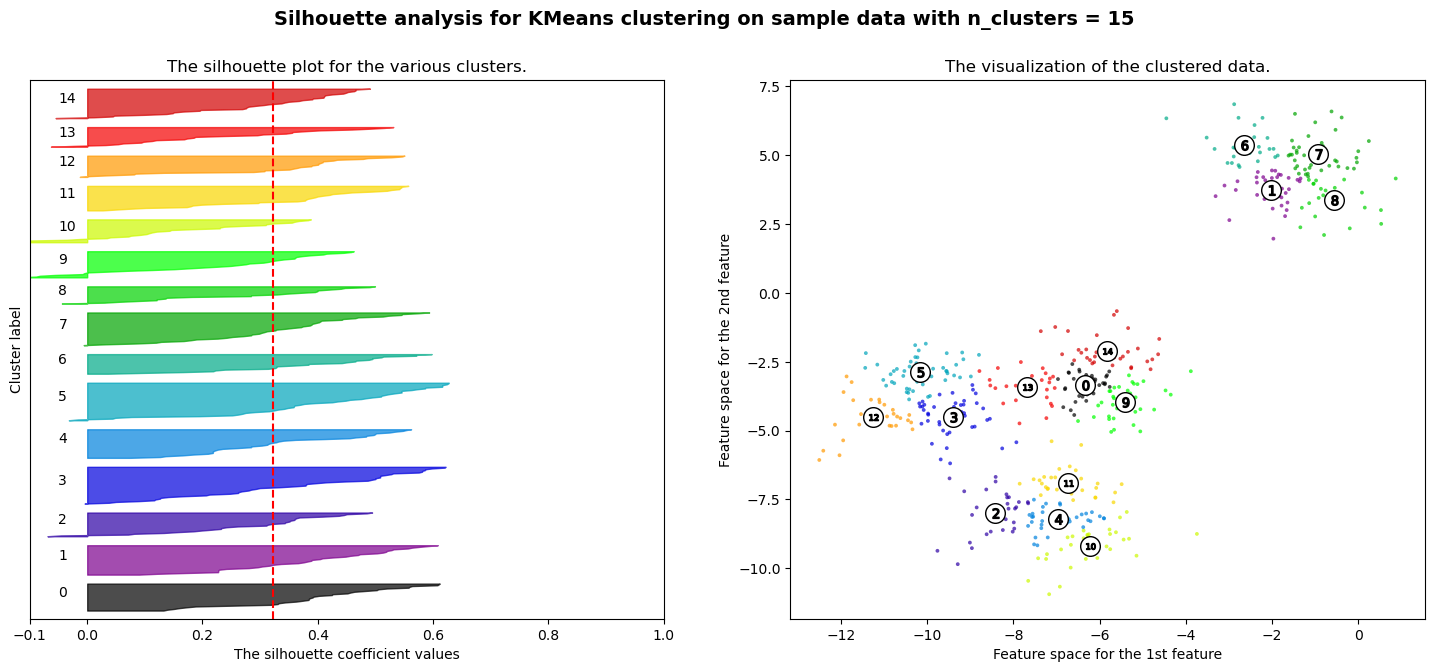

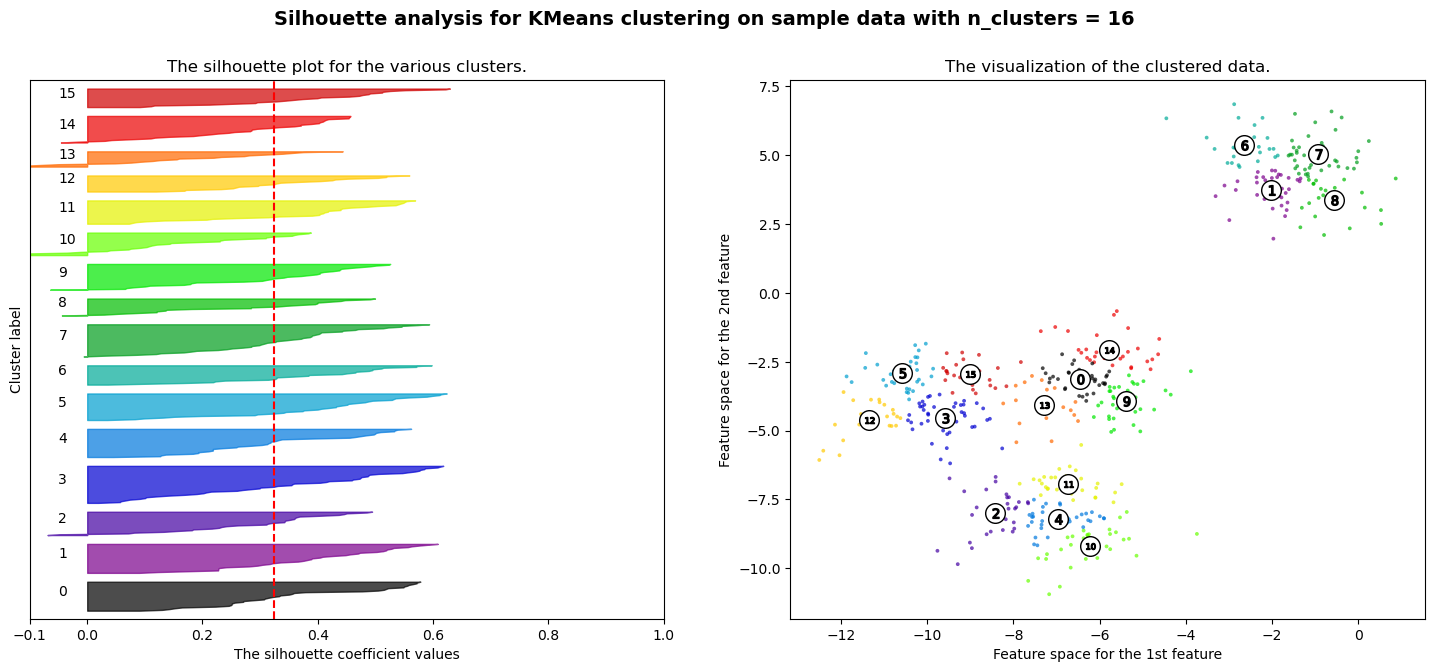

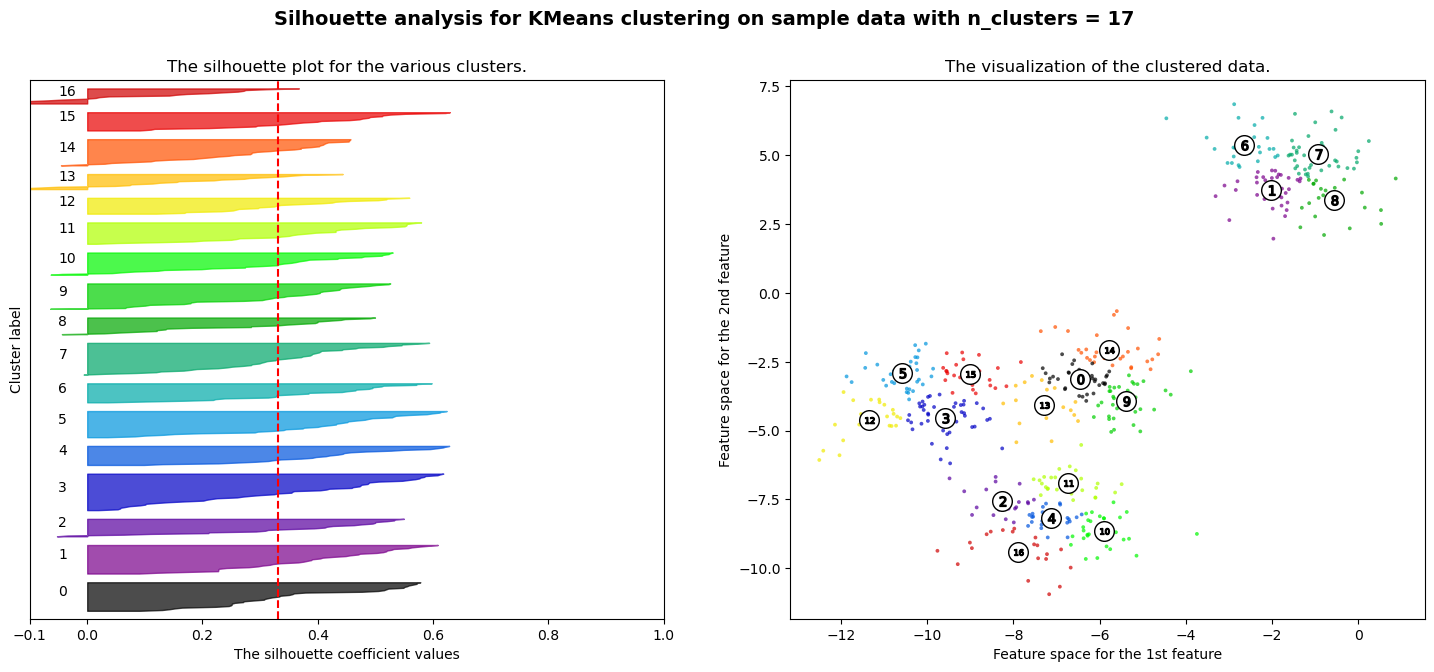

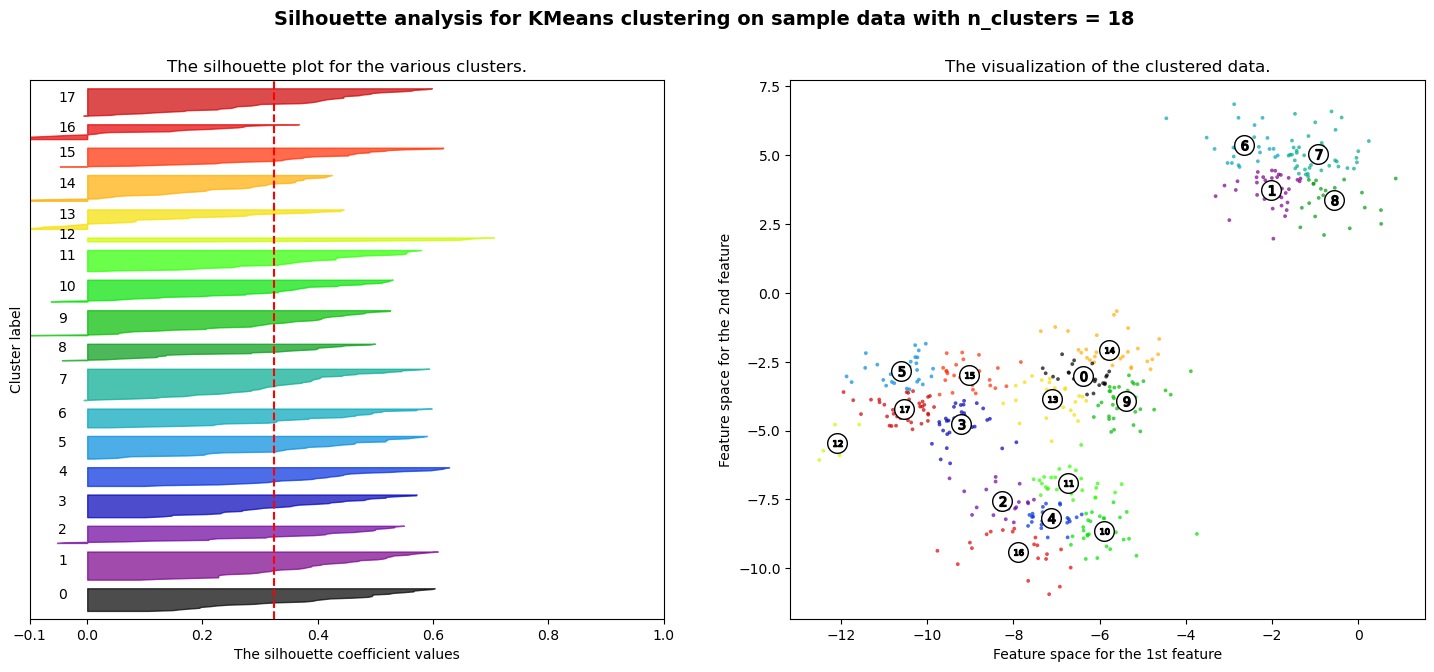

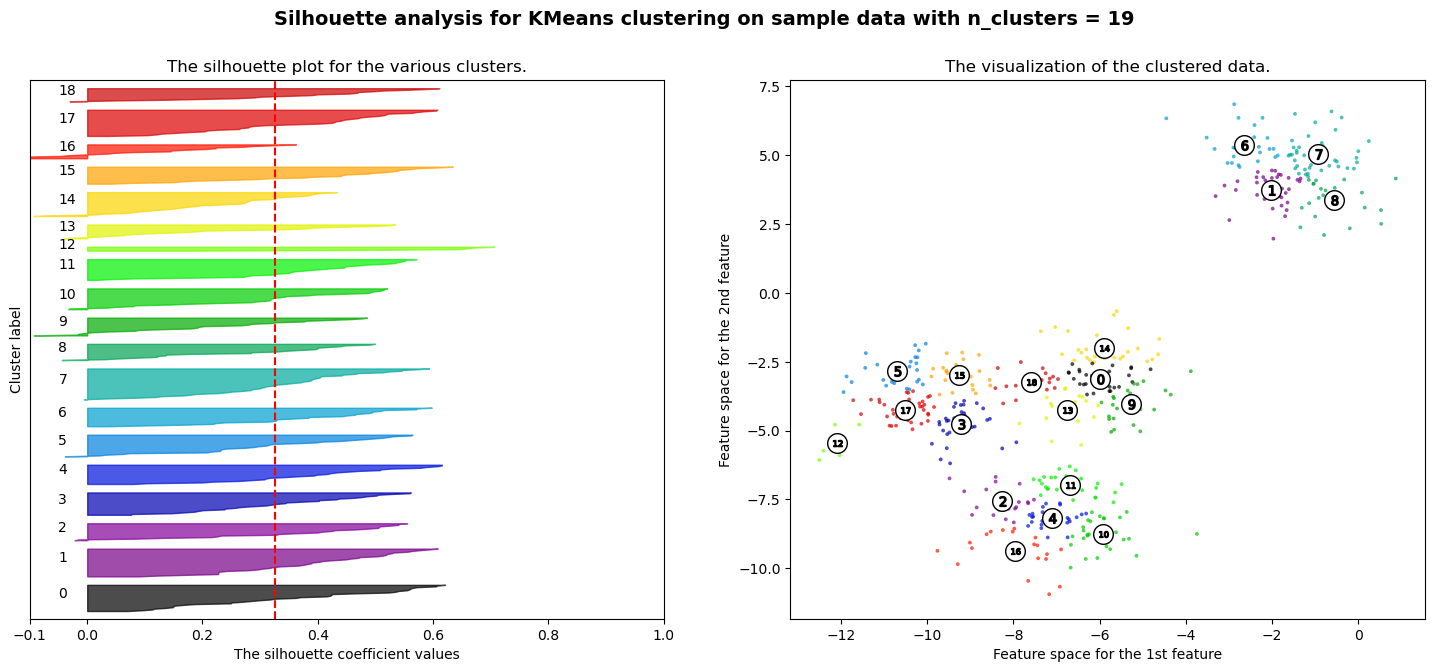

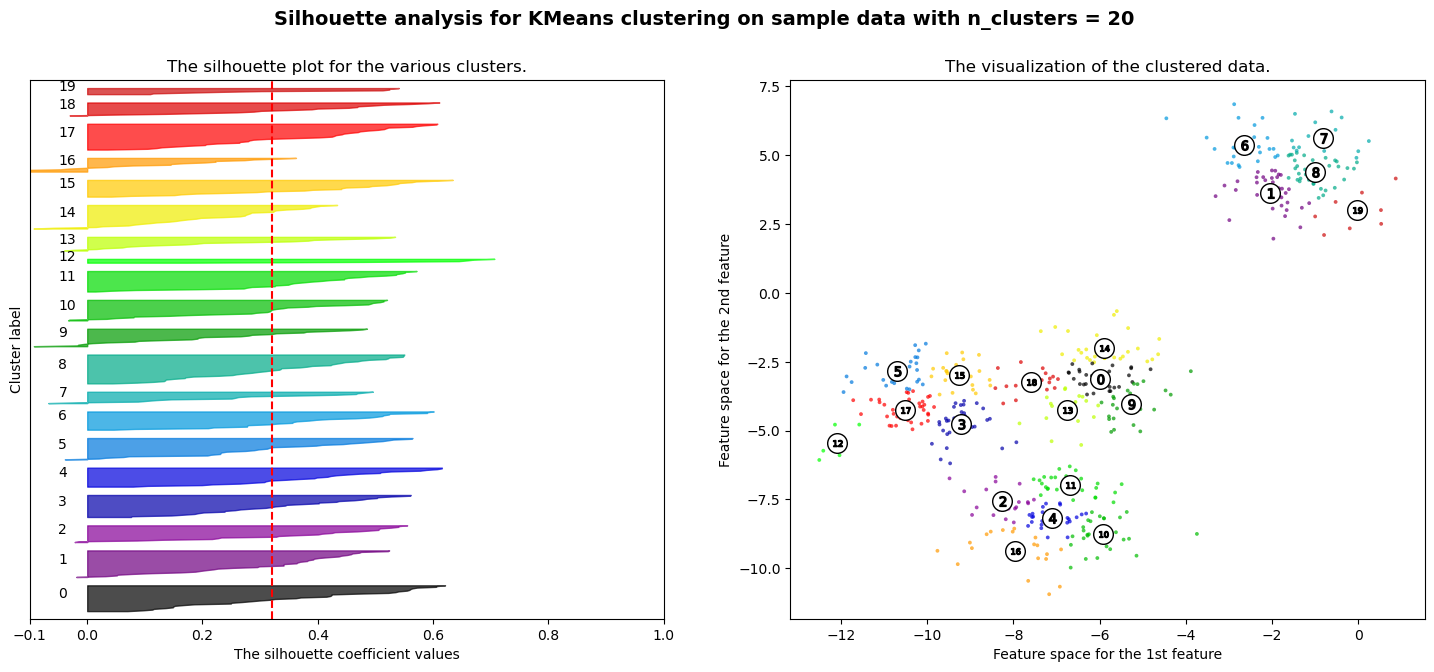

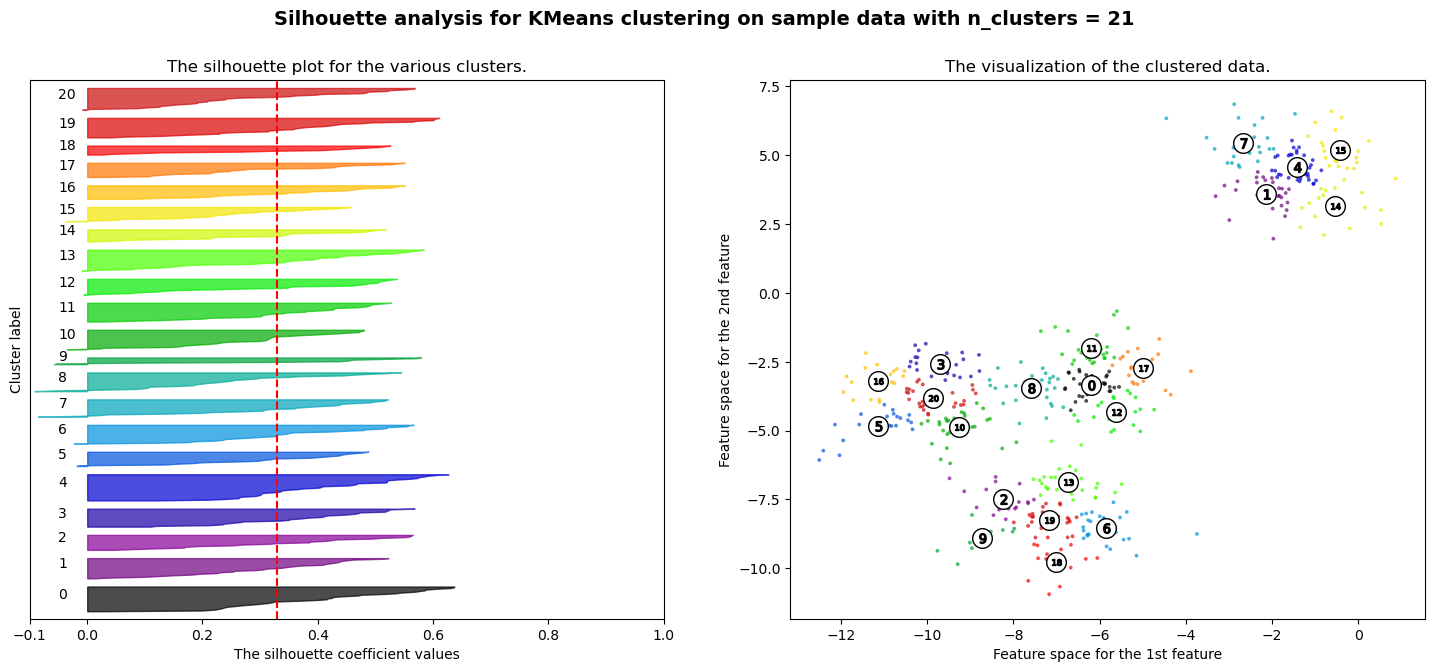

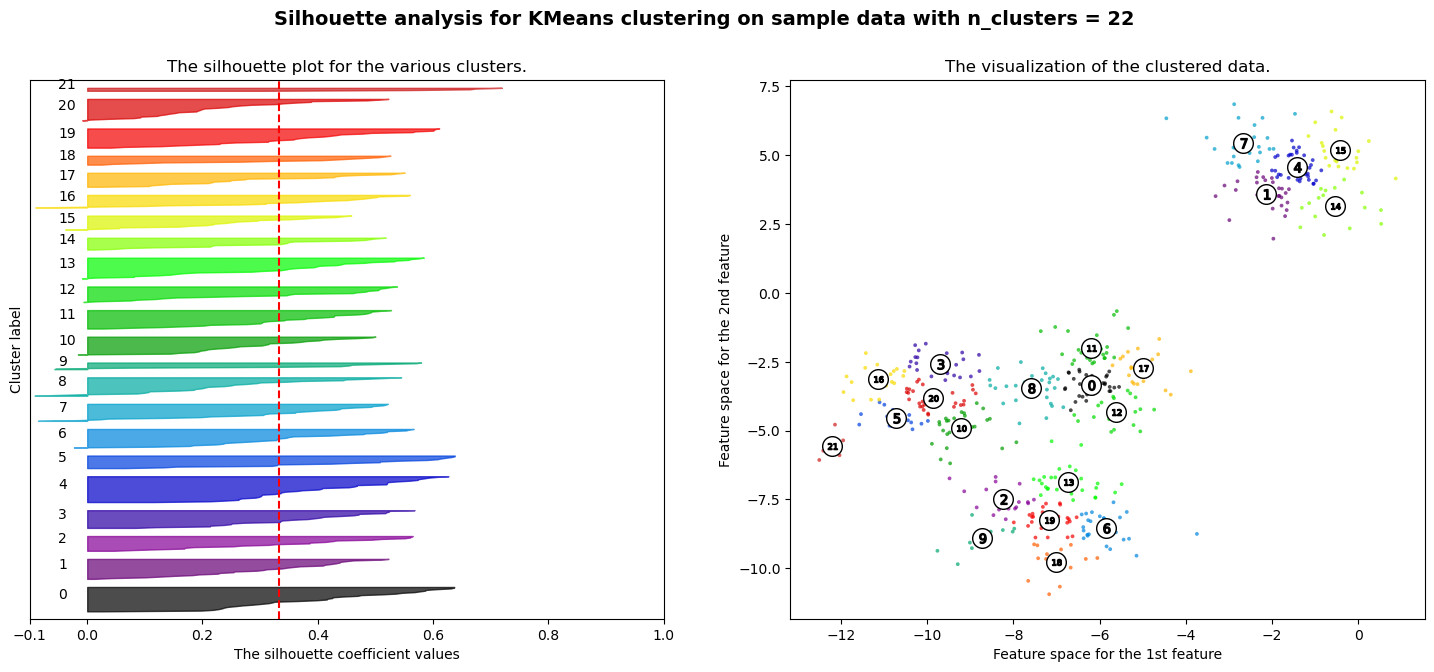

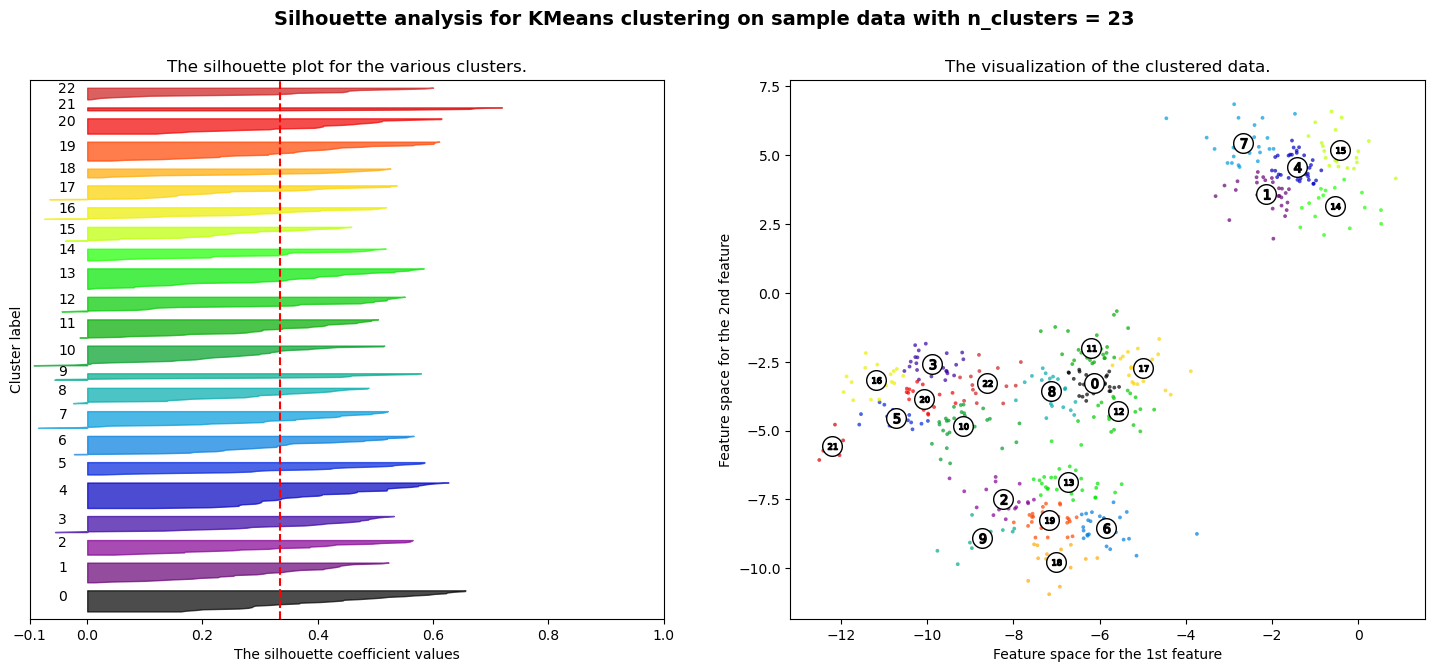

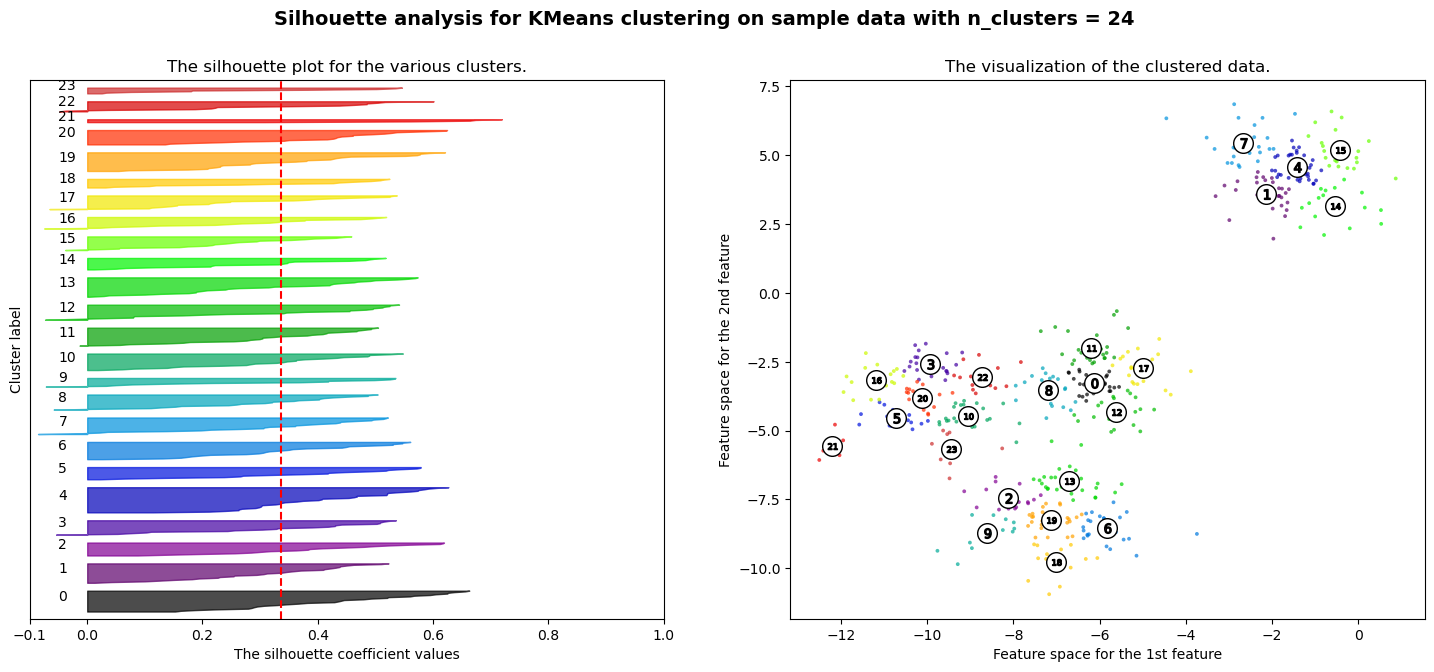

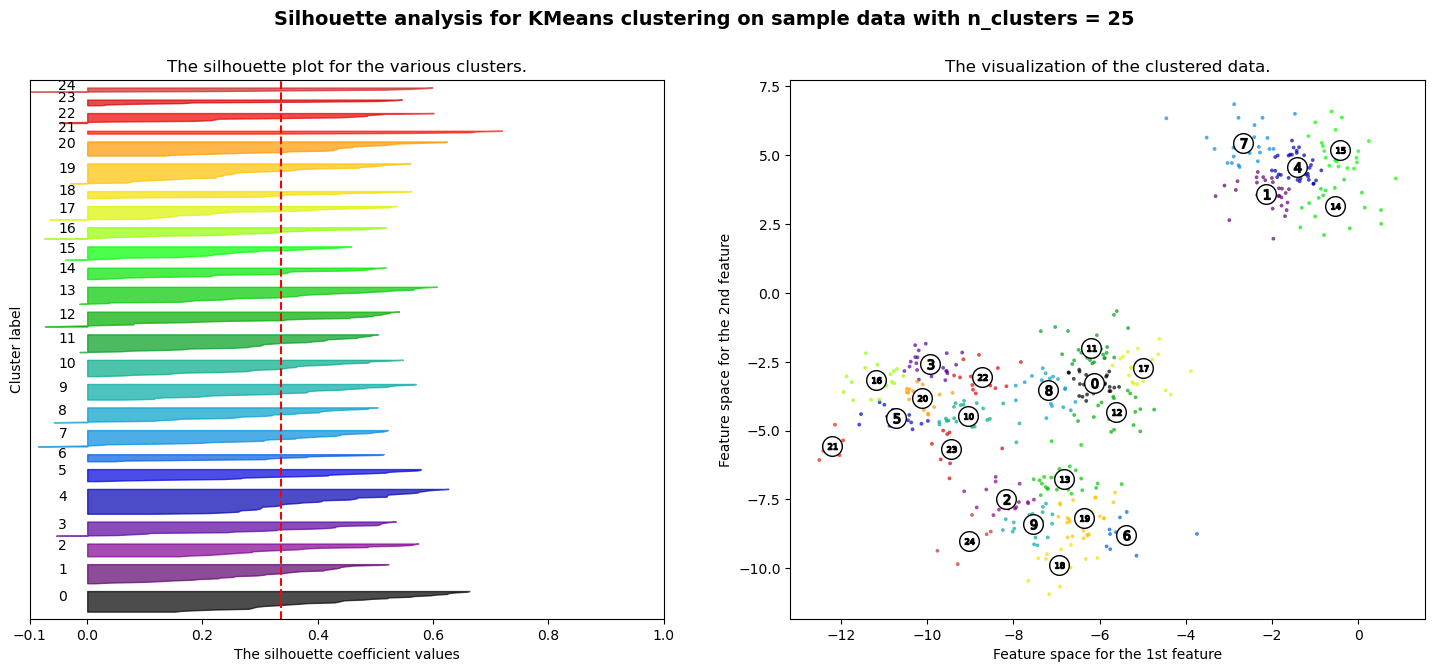

In [34]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility


range_n_clusters = np.arange(2, 26)


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


error cuadratico medio:
 0.032525774576955636
error cuadratico medio:
 0.029302584718107


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


error cuadratico medio:
 0.008031543439162455
error cuadratico medio:
 0.0008198828199851045


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


error cuadratico medio:
 0.0006093563830547696


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


error cuadratico medio:
 5.6312654915457564e-05


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


error cuadratico medio:
 4.089680594370266e-05


C:\Users\Francisco\AppData\Local\Temp\ipykernel_28744\3454046904.py:188: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,8))
C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


error cuadratico medio:
 2.7418441649803674e-05


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


error cuadratico medio:
 2.282513498435071e-05


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


error cuadratico medio:
 1.8792053006708488e-05


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


error cuadratico medio:
 1.605759493347939e-05


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


error cuadratico medio:
 1.6570869135663947e-05


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


error cuadratico medio:
 1.6448850333633997e-05


C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


error cuadratico medio:
 1.56695537159933e-05


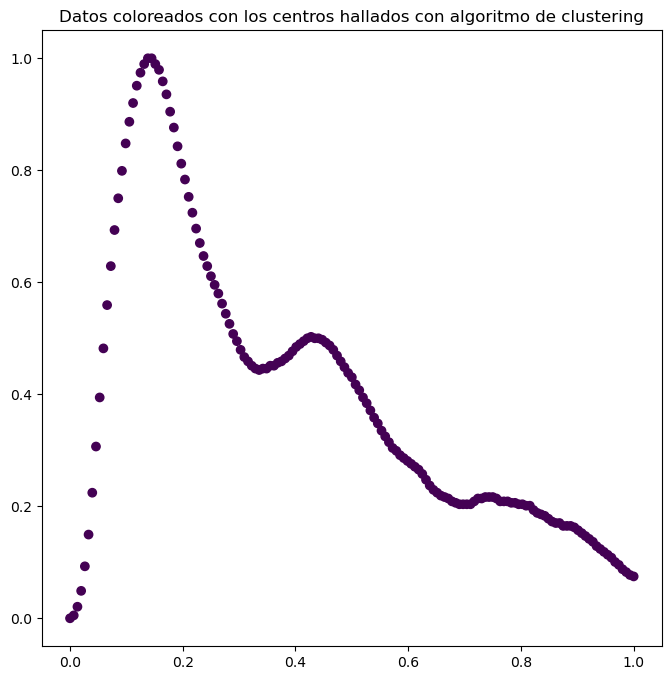

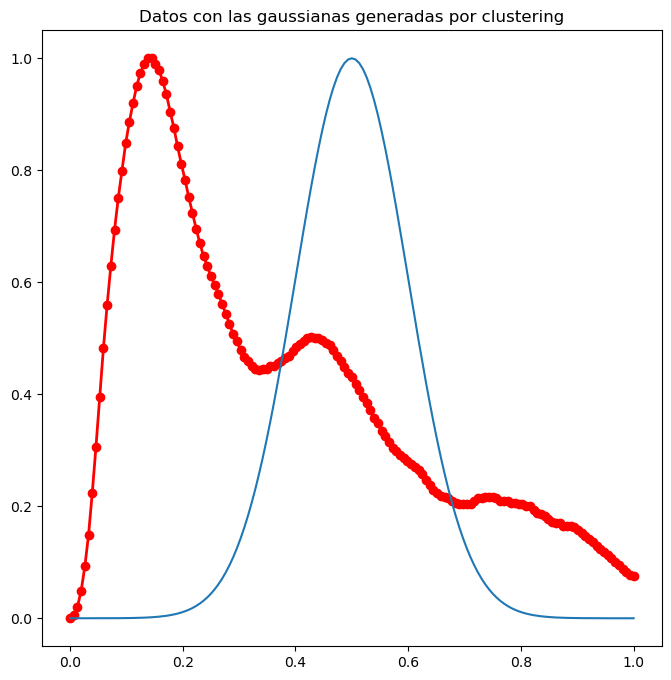

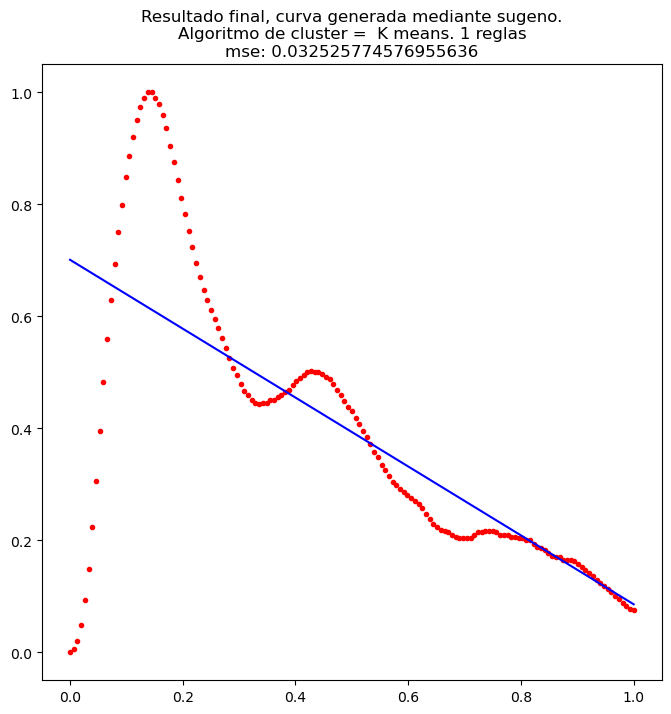

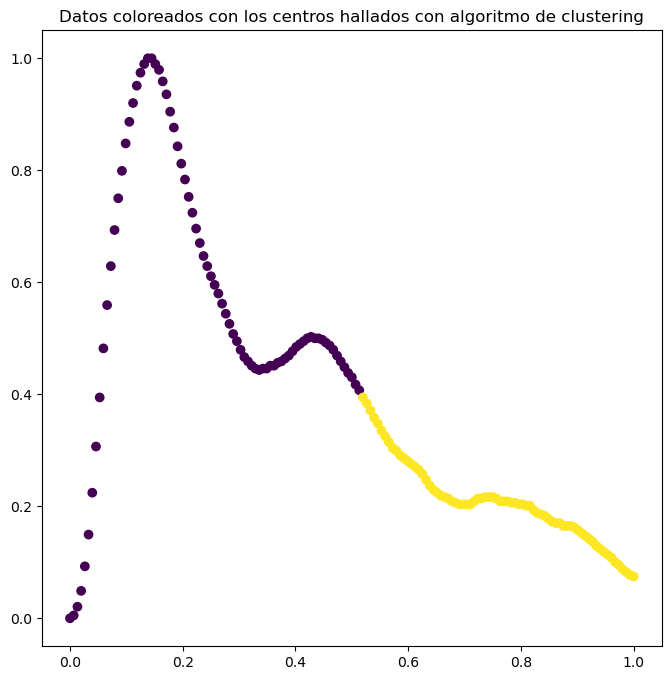

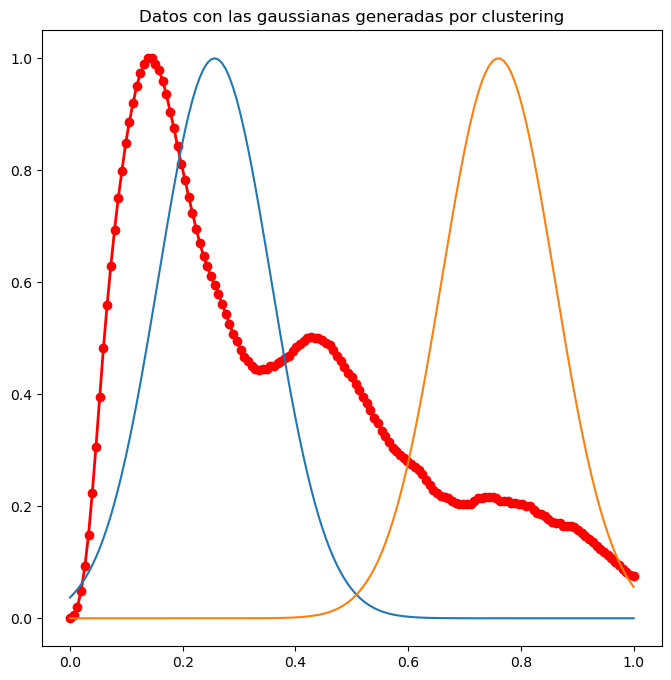

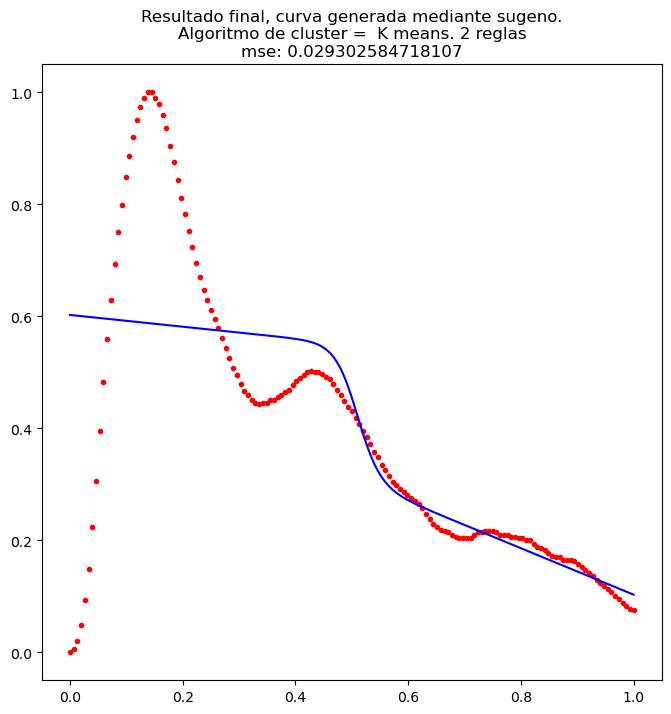

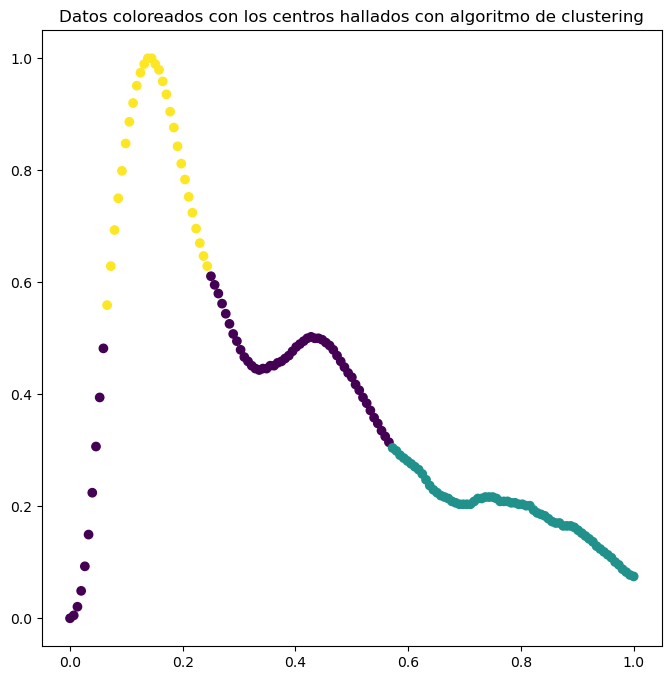

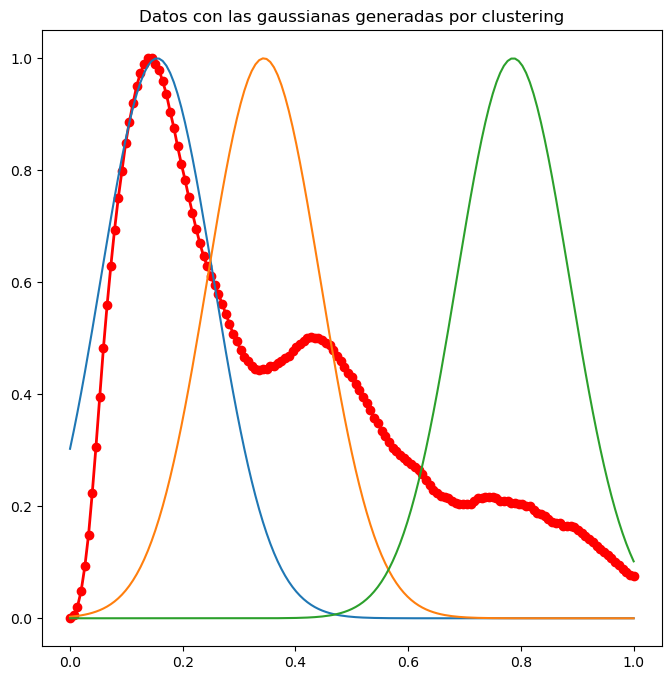

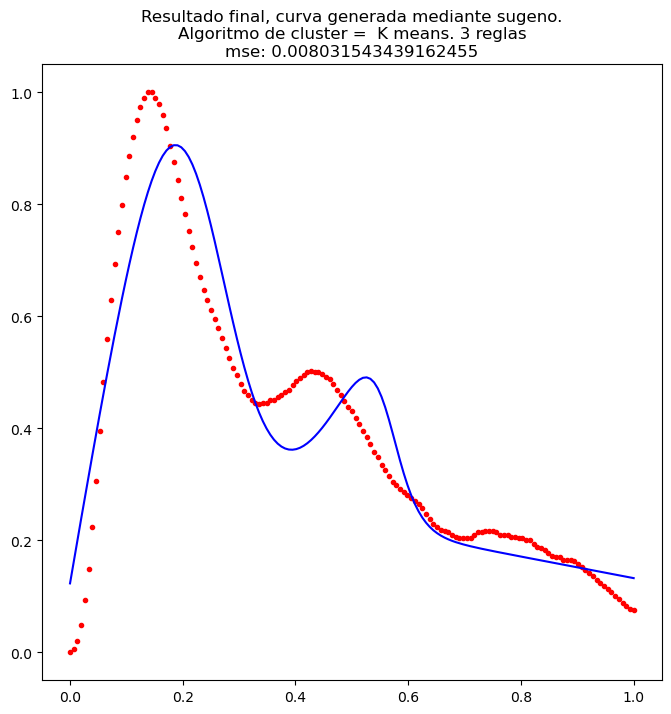

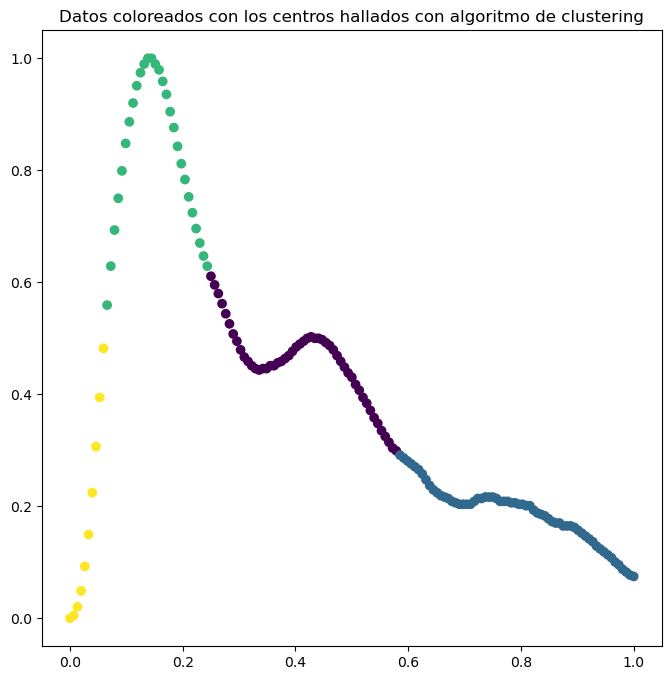

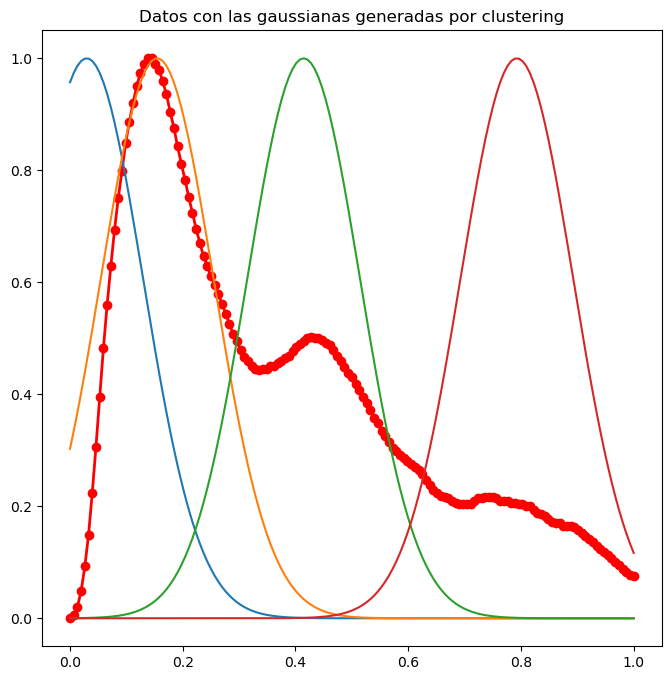

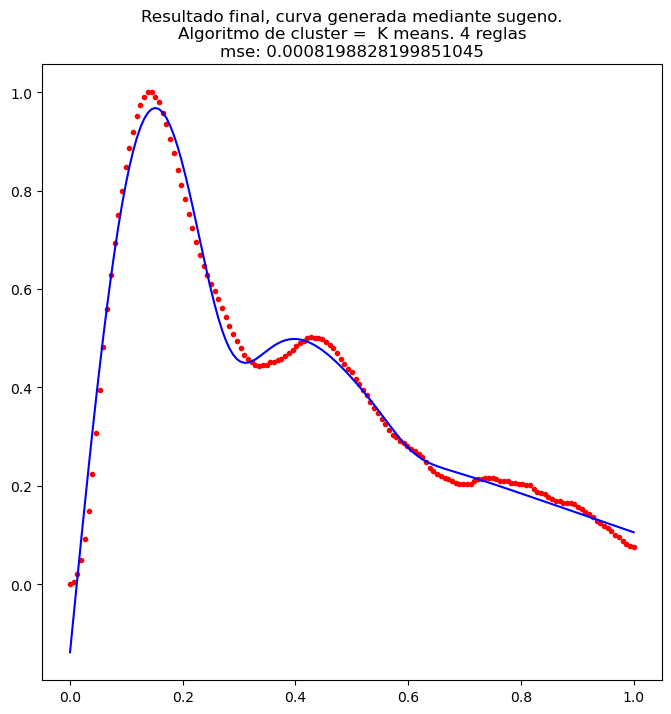

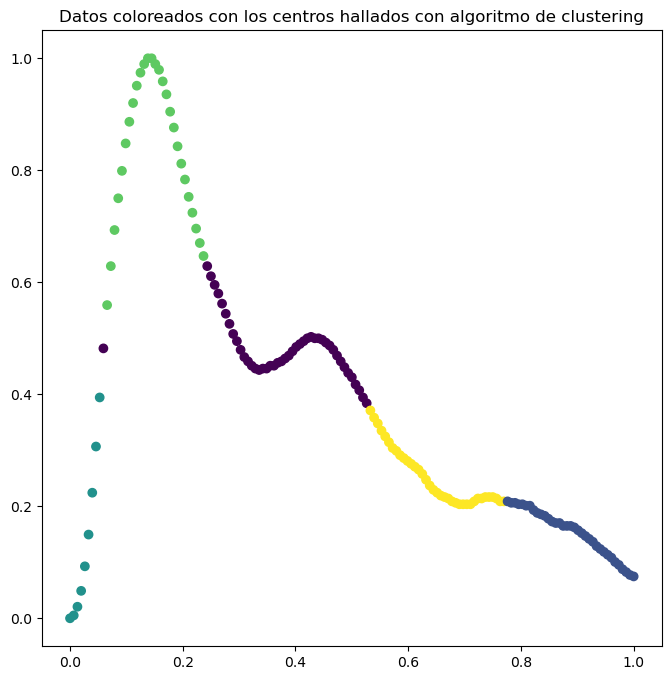

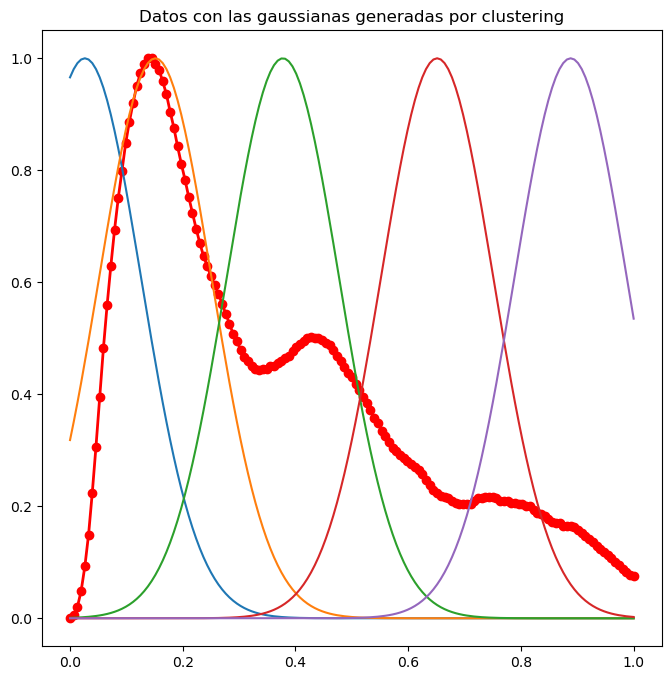

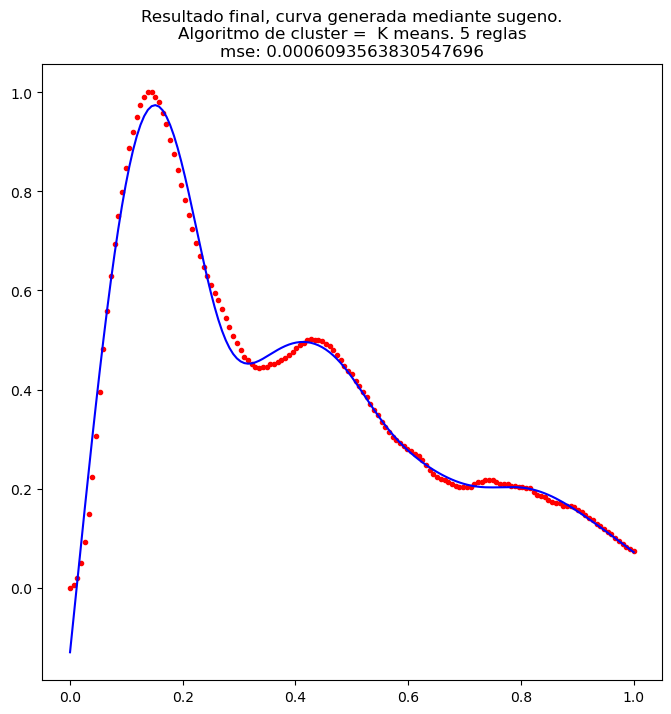

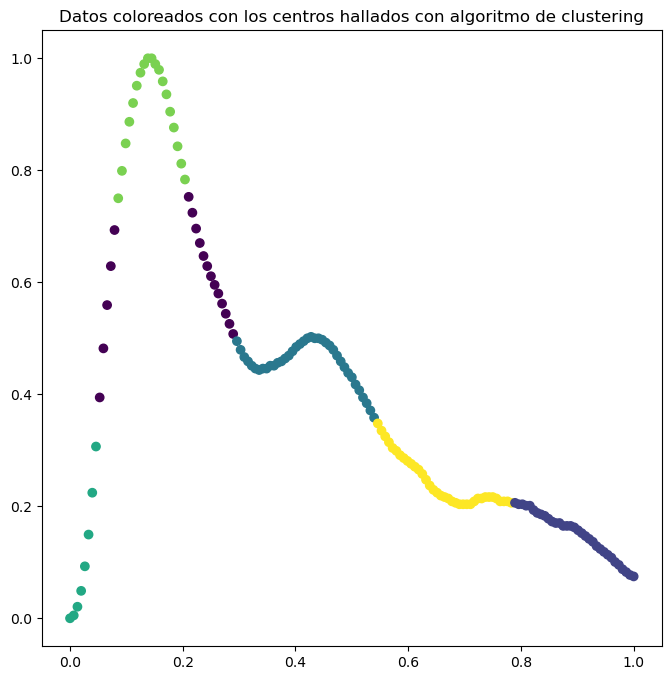

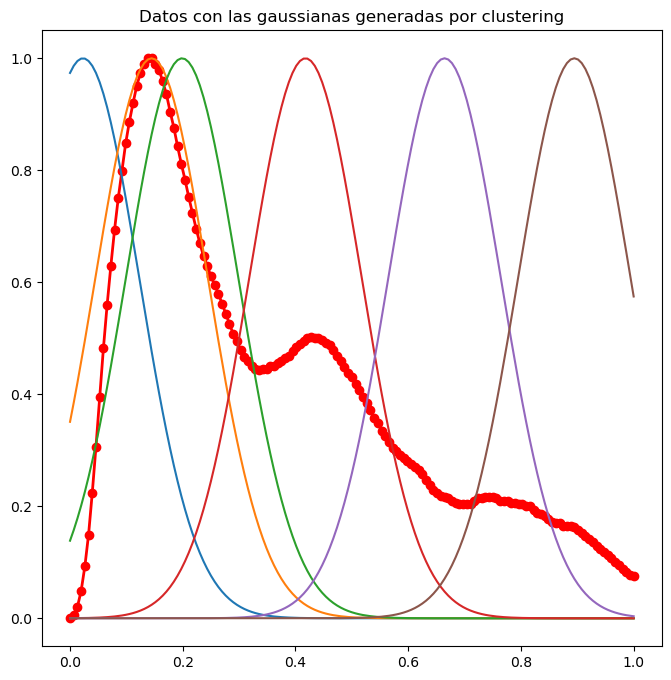

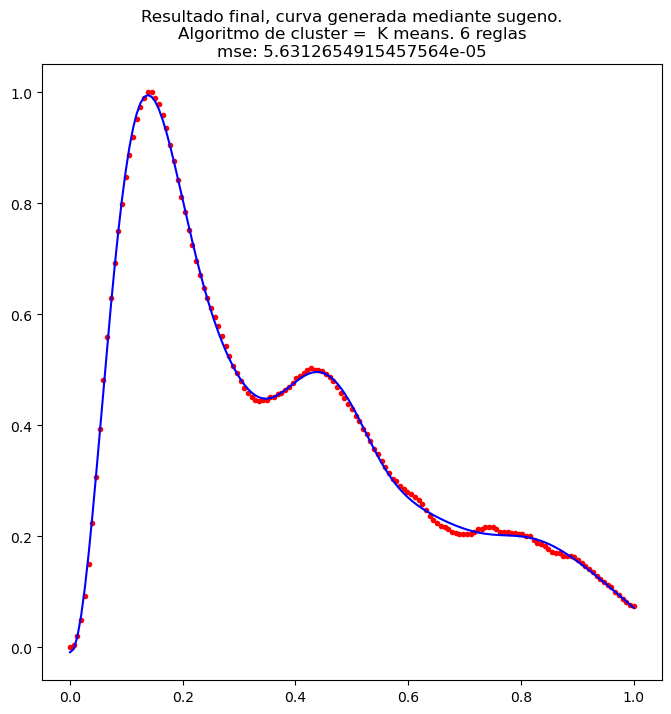

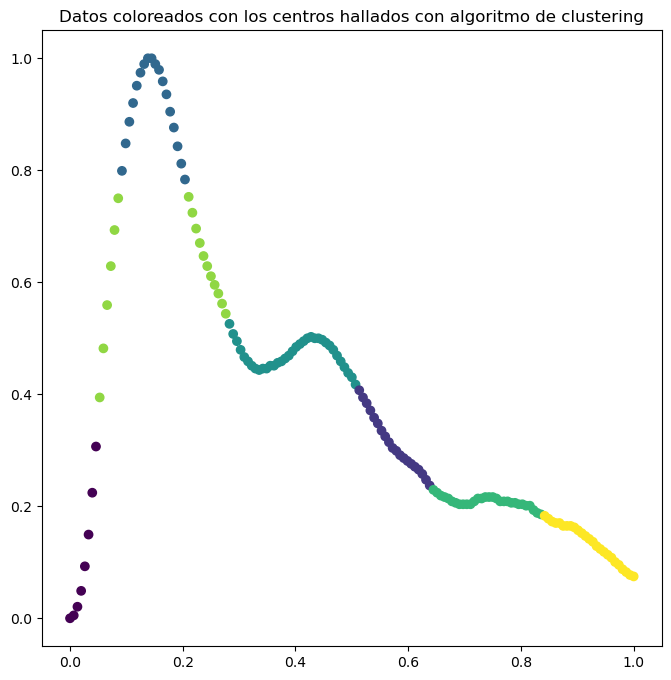

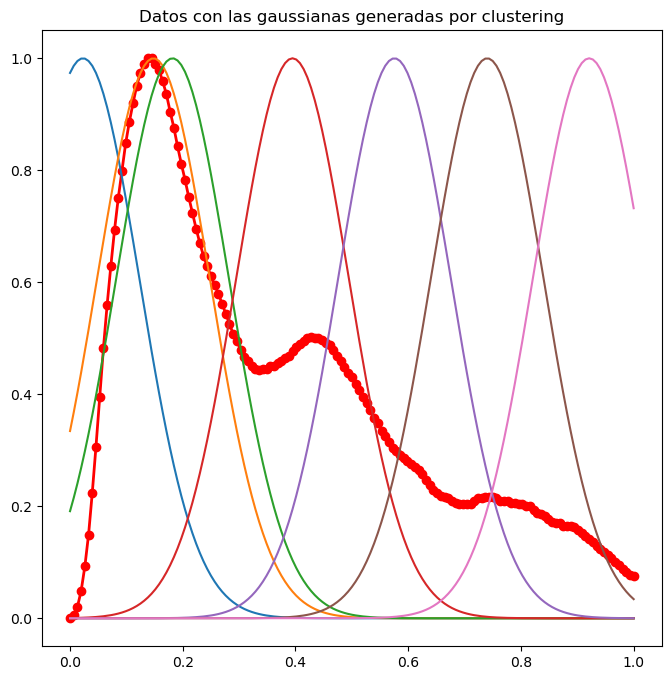

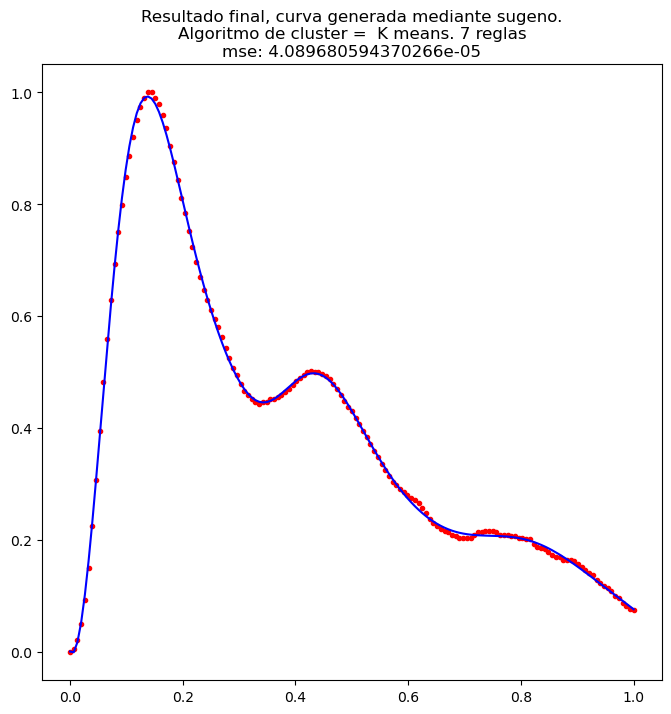

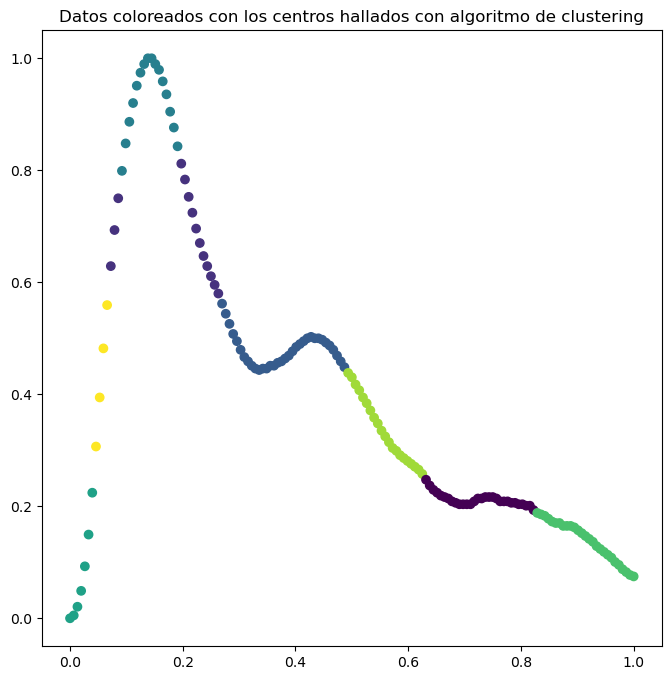

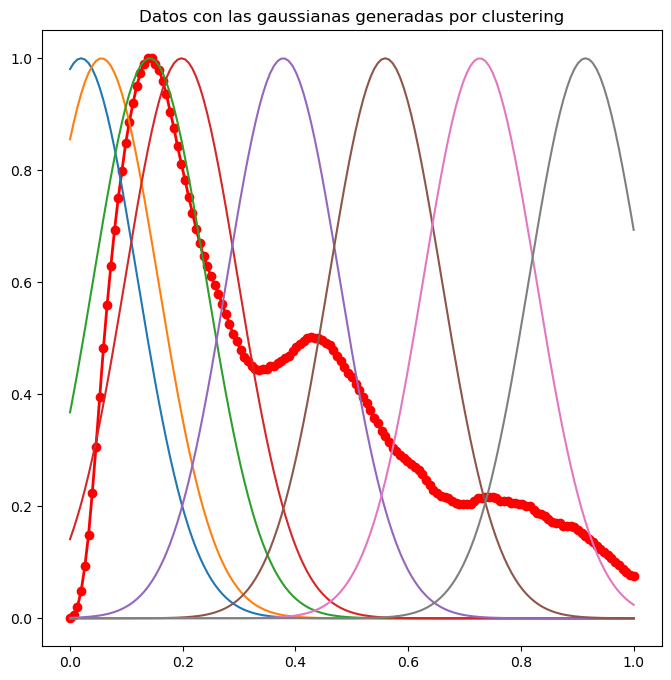

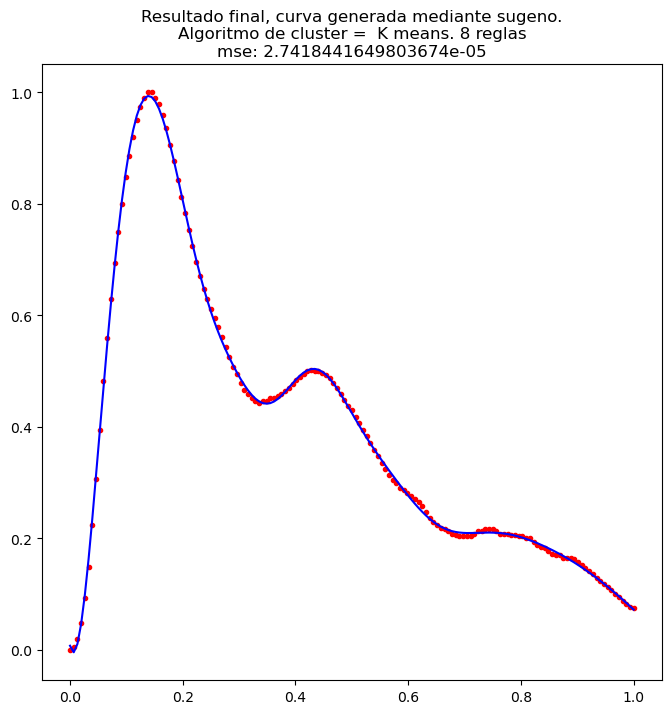

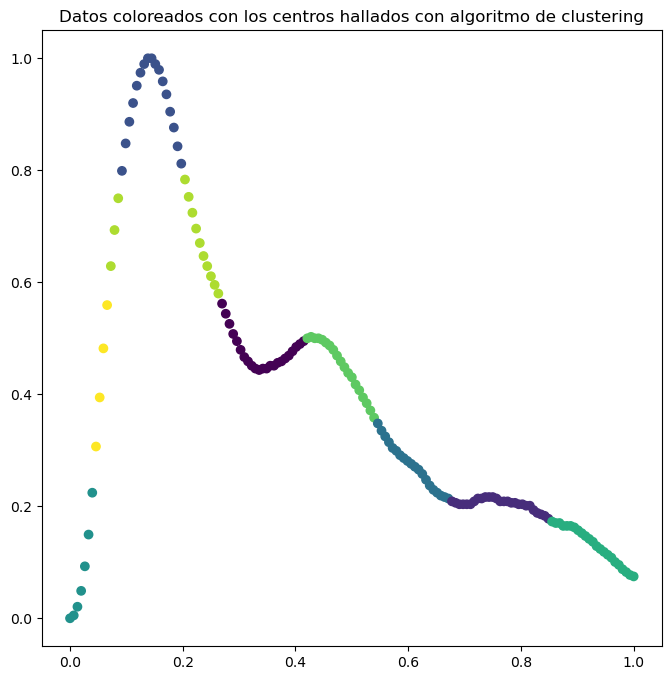

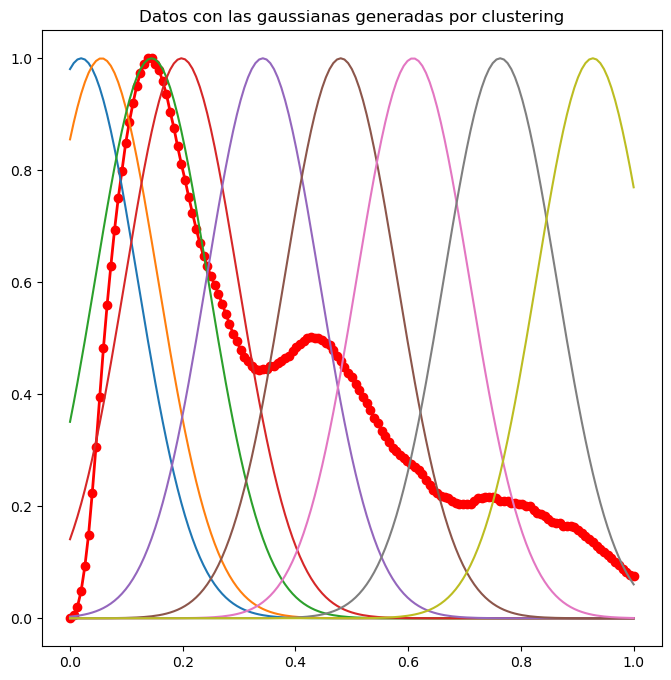

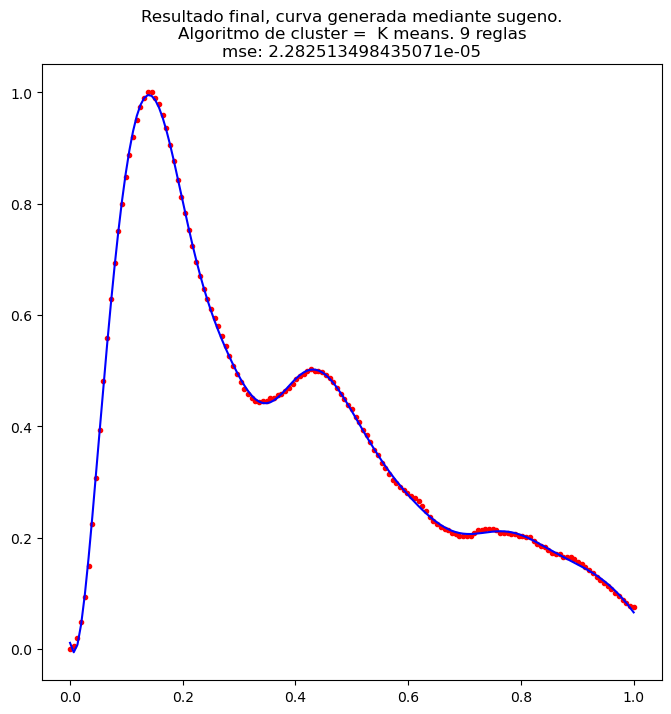

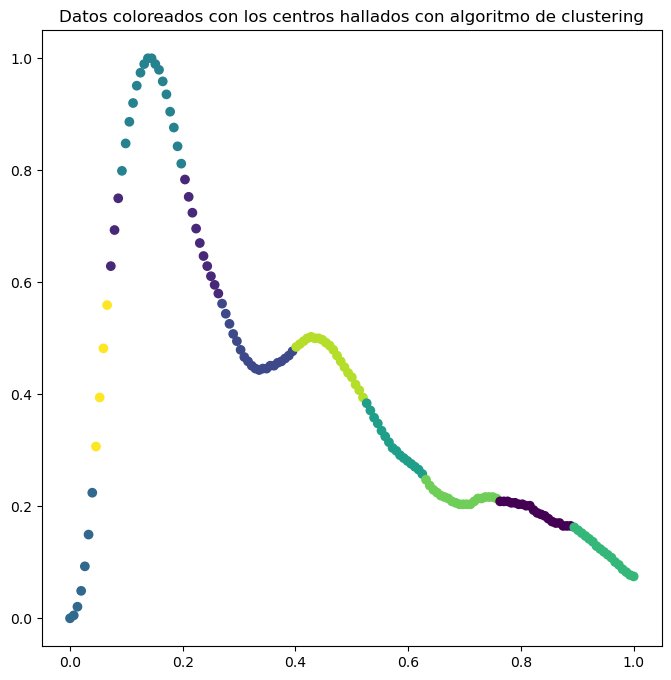

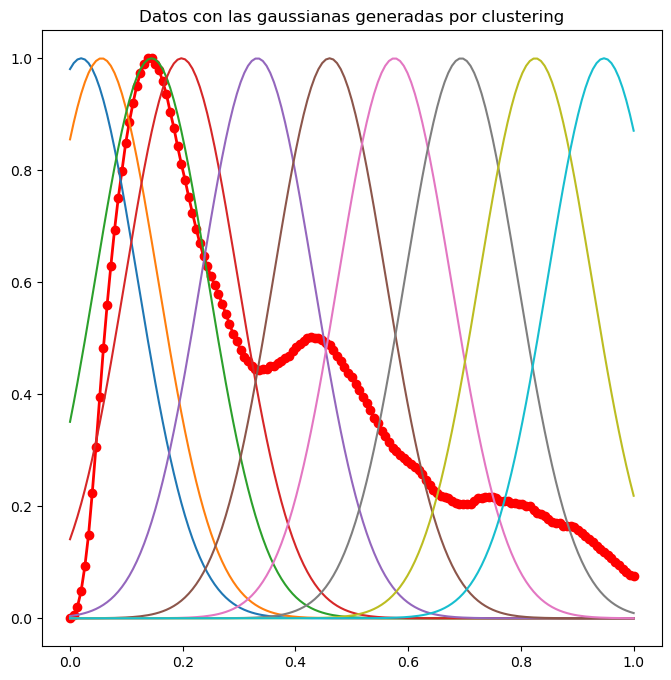

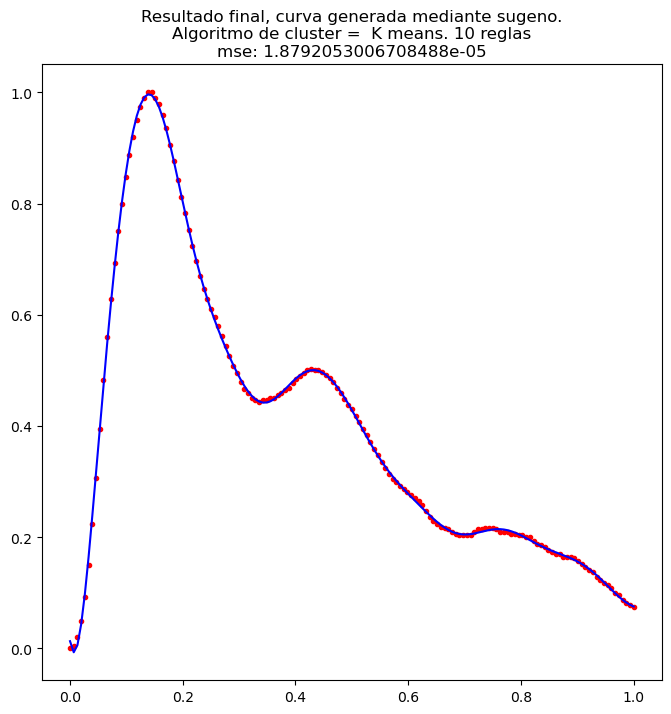

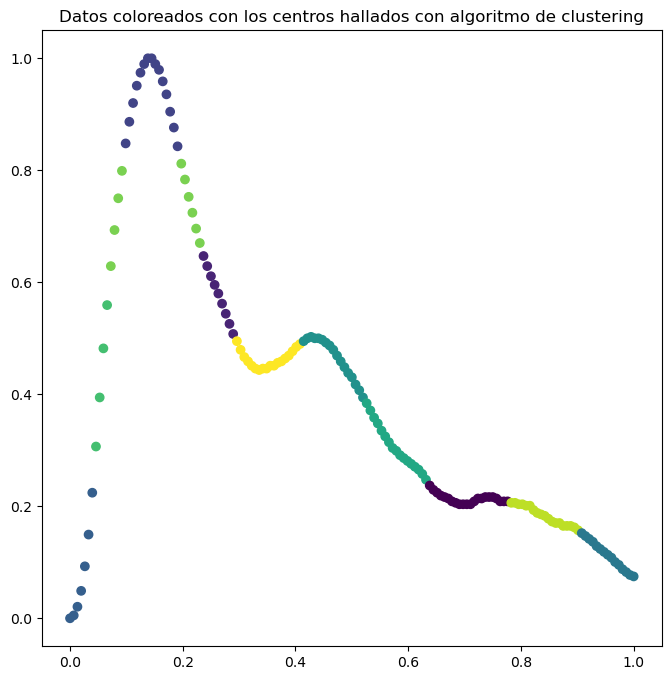

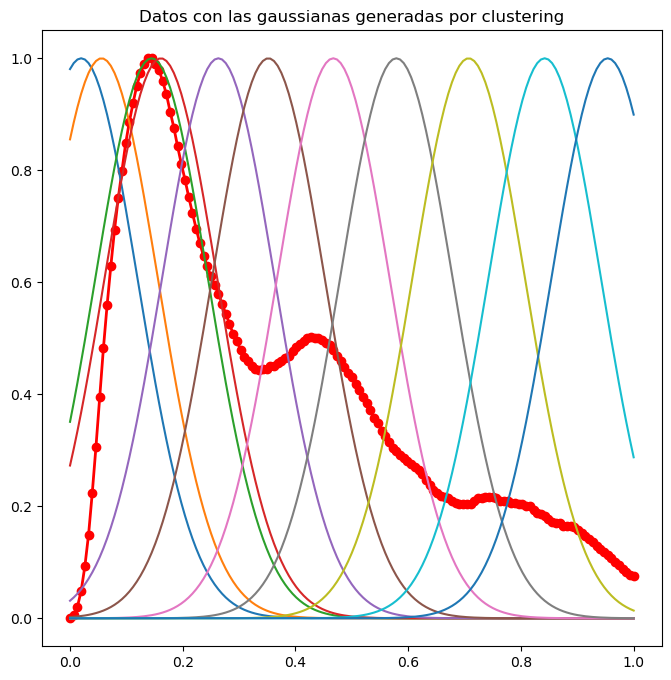

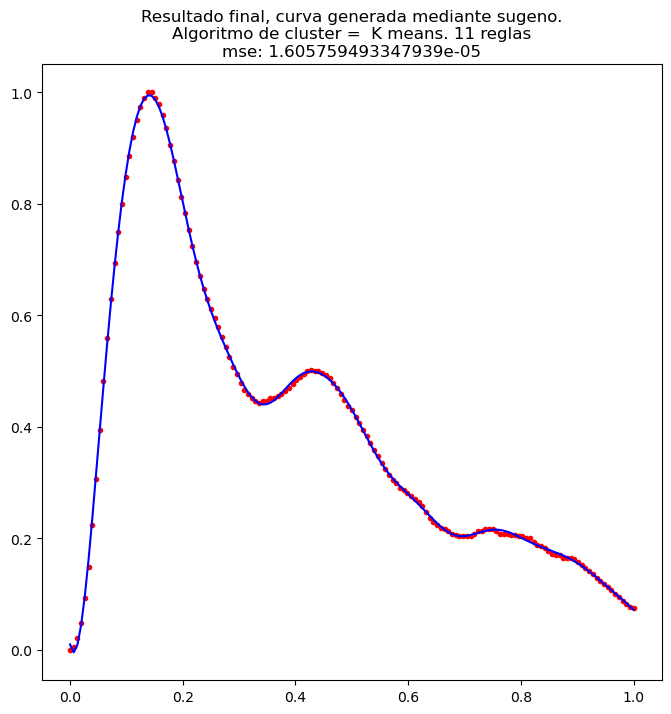

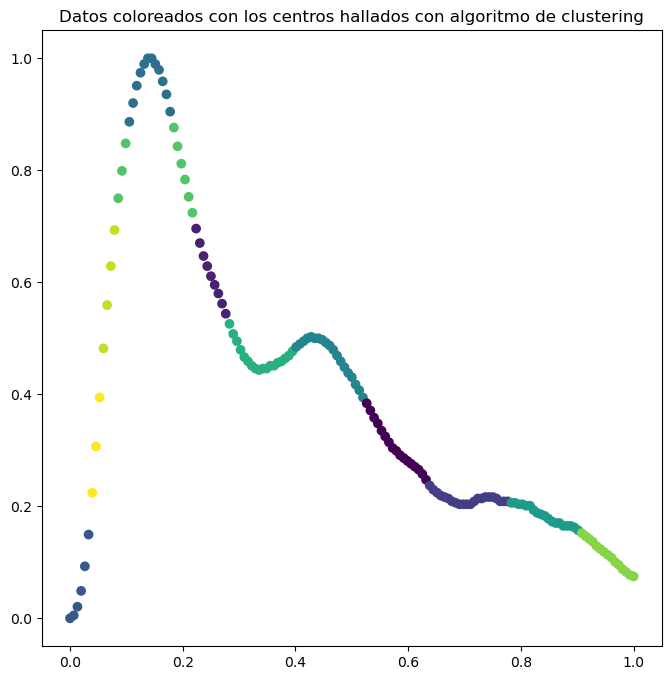

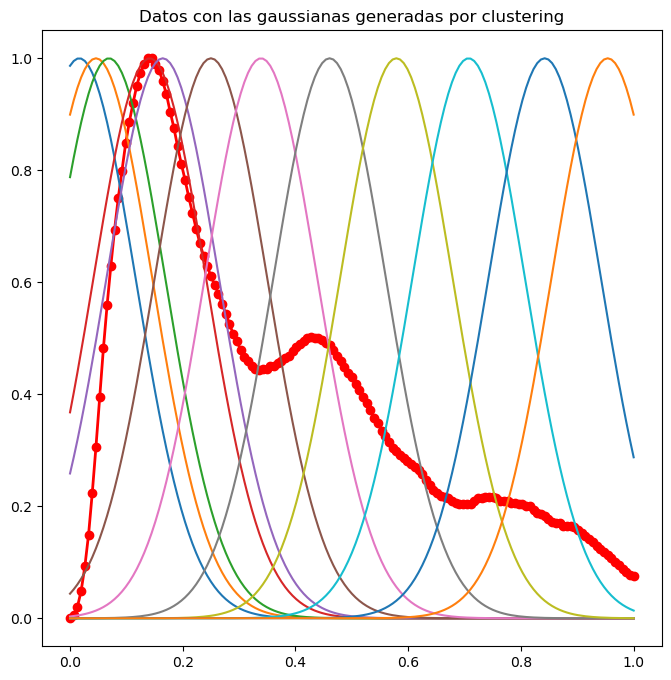

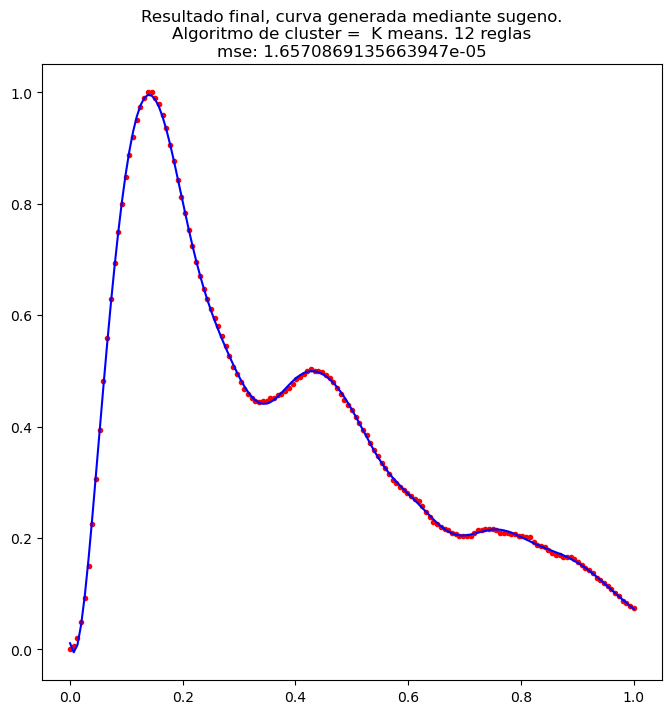

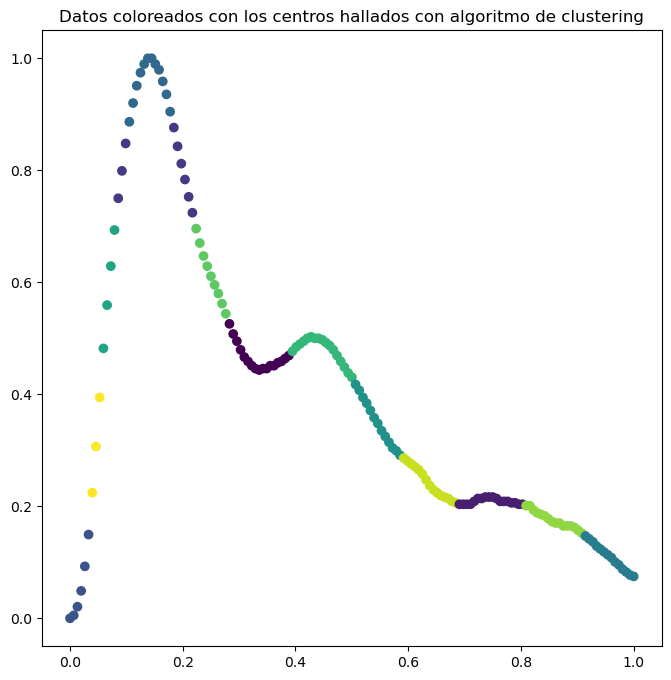

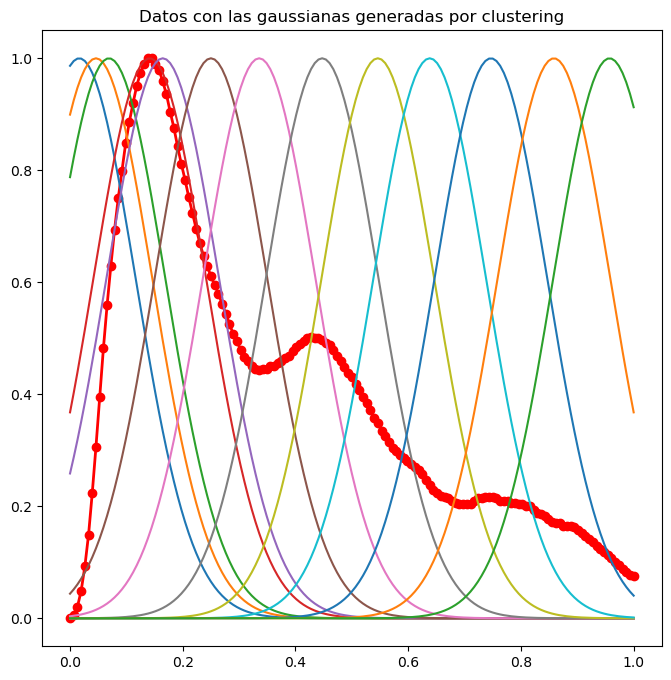

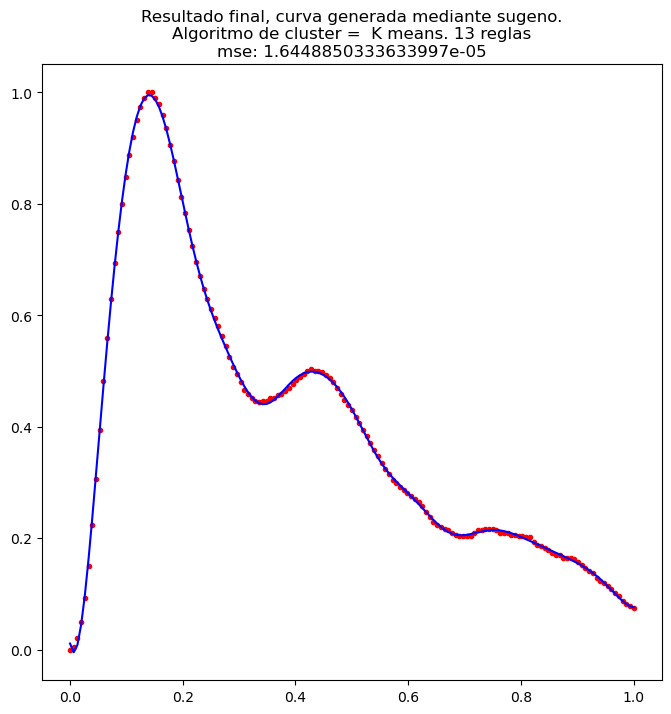

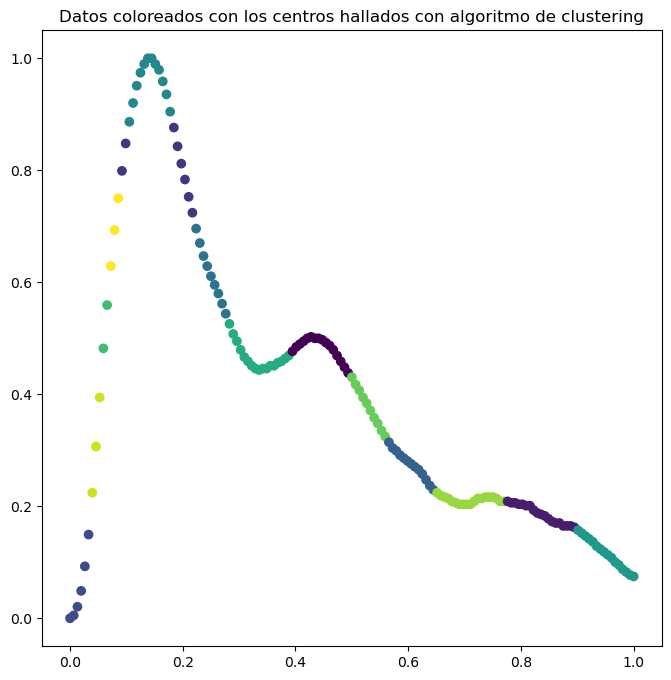

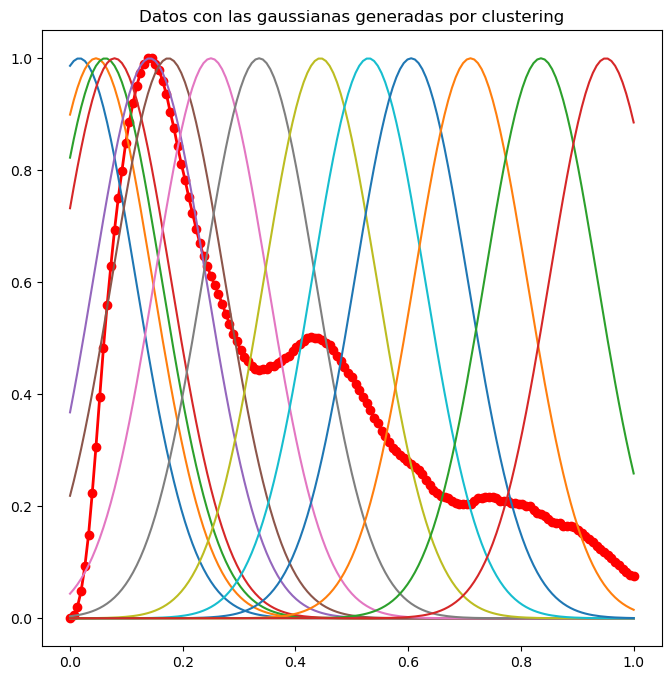

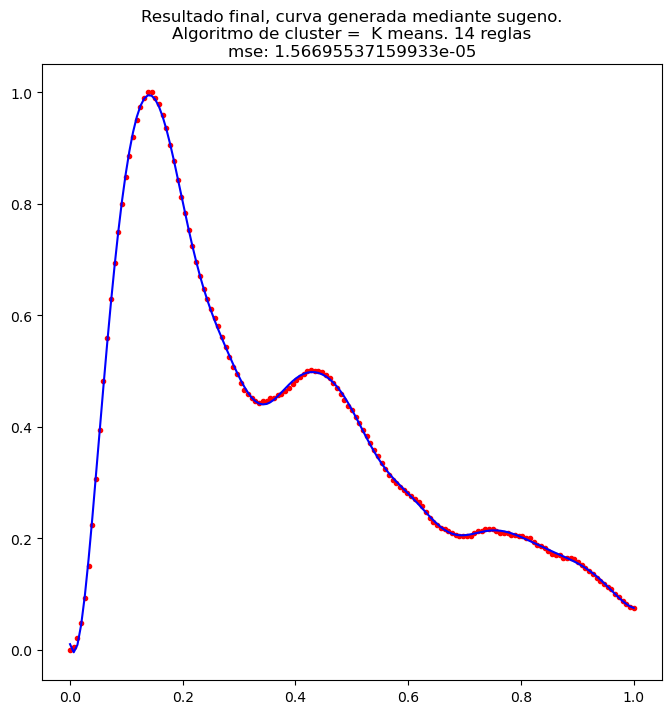

In [35]:
for i in range(1, 15):
    my_sug_VDA = Sugeno(X11, cluster_alg="K", K=i,Ra=0.4)
    my_sug_VDA.fit_clusters()
    my_sug_VDA.plot_original_color_by_cluster()
    my_sug_VDA.plot_gaussians()
    my_sug_VDA.get_sugeno_model_and_plot()

C:\Users\Francisco\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


error cuadratico medio:
 1.605759493347939e-05
[0.003289473684210526, 0.009868421052631578, 0.01644736842105263, 0.023026315789473683, 0.029605263157894735, 0.03618421052631579, 0.042763157894736836, 0.049342105263157895, 0.05592105263157894, 0.0625, 0.06907894736842105, 0.0756578947368421, 0.08223684210526315, 0.08881578947368421, 0.09539473684210525, 0.10197368421052631, 0.10855263157894736, 0.11513157894736842, 0.12171052631578946, 0.1282894736842105, 0.13486842105263158, 0.14144736842105263, 0.14802631578947367, 0.15460526315789475, 0.16118421052631576, 0.16776315789473684, 0.17434210526315788, 0.18092105263157893, 0.1875, 0.19407894736842105, 0.2006578947368421, 0.20723684210526316, 0.21381578947368418, 0.22039473684210525, 0.2269736842105263, 0.23355263157894735, 0.24013157894736842, 0.24671052631578946, 0.2532894736842105, 0.2598684210526315, 0.26644736842105265, 0.2730263157894737, 0.2796052631578947, 0.2861842105263158, 0.29276315789473684, 0.29934210526315785, 0.3059210526315

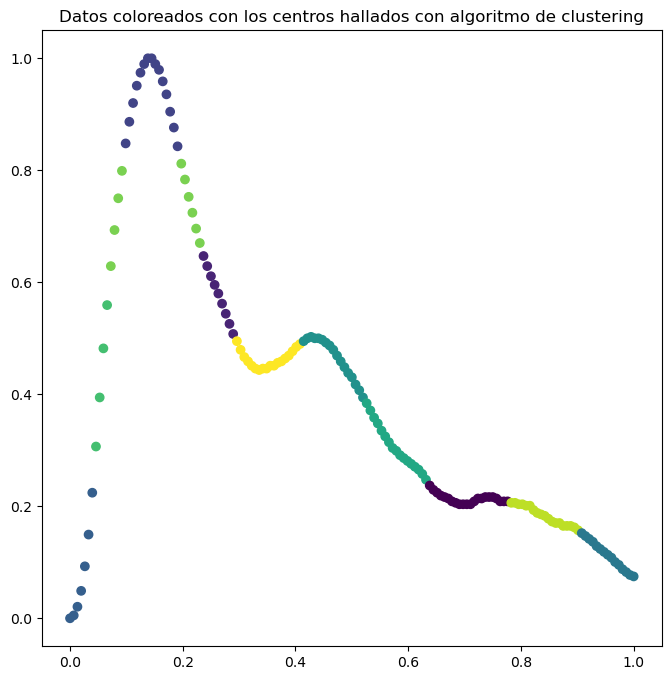

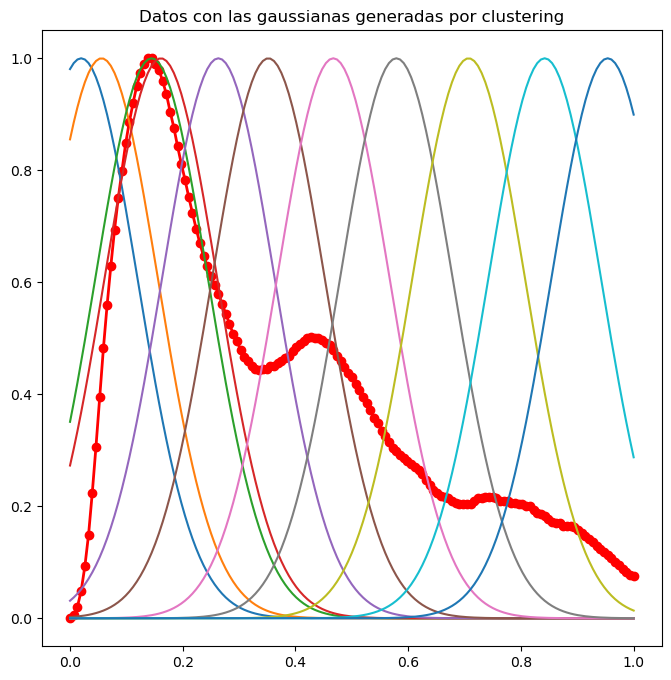

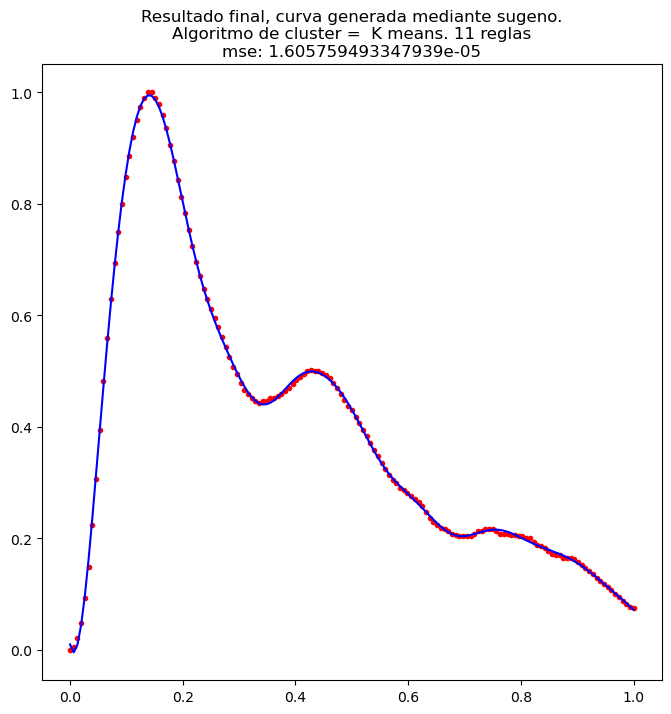

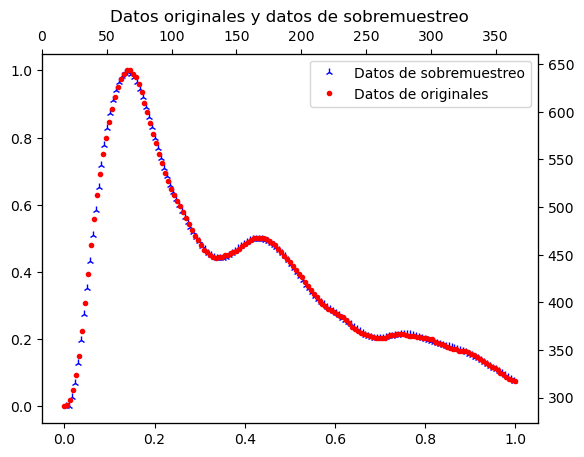

In [36]:
#Hacemos el sobremuestreo apartir del la cantidad de reglas elegidas

my_sug_VDA = Sugeno(X11, cluster_alg="K", K=11,Ra=0.4)
my_sug_VDA.fit_clusters()
my_sug_VDA.plot_original_color_by_cluster()
my_sug_VDA.plot_gaussians()
my_sug_VDA.get_sugeno_model_and_plot()
my_sug_VDA.get_oversampling_and_plot(MAXX,MAXY,0,MINY)